In [2]:
import os
import numpy as np
import pickle
import pandas as pd
from scipy.stats import zscore
from brainbox.io.one import SessionLoader
from sklearn.preprocessing import StandardScaler
import gc
import concurrent.futures

from functions import merge_licks, resample_common_time, interpolate_nans, low_pass
from one.api import ONE
one = ONE(mode='remote')

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [4]:
""" Load BWM data post-QC """

data_path = prefix + '/representation_learning_variability/paper-individuality/'
filename = '1_bwm_qc_07-10-2025'



data_path = prefix + 'representation_learning_variability/Video and wheel/Video QC/'
filename = 'final_lp_qc07-10-2025'


bwm_query = pickle.load(open(data_path+filename, "rb"))


/tmp/ipykernel_10759/431073403.py:13: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  bwm_query = pickle.load(open(data_path+filename, "rb"))


In [3]:
extra_sessions = ['2d7c0f7f-e805-404b-914a-23d83998e08e',
'7691eeb3-715b-4571-8fda-6bb57aab8253',
'a28746ff-a6e0-403d-a11d-893c2f9a44b4',
'f140a2ec-fd49-4814-994a-fe3476f14e66',
'bd8b204f-a42e-45c1-a8f0-71c6223a6657',
'e4fac833-d985-4bb2-a97a-c4d7ed8d06e1',
'13b70283-e8d3-4e69-ae3f-83f50c9602e2',
'e34ee0ad-3ad8-4faa-b4d5-c1cc0cf3b496',
'f3eeb2d4-87ce-49ae-8a74-21665f6f1536',
'd9f0c293-df4c-410a-846d-842e47c6b502',
'86f741b4-9dee-4c28-8ee9-49f3656ab419',
'650a0a90-4bf3-4489-9bcd-75baf0a49eac',
'a2be3311-de26-48b3-bfc7-317e94a4fdd3',
'12f95449-6914-4d76-9eb3-7d79757a4a77',
'd9907ac3-7378-471d-91fb-c8ec34870e17',
'b4a8ec28-46ad-4b6f-908b-650d0970a0db',
'c51f34d8-42f6-4c9c-bb5b-669fd9c42cd9',
'71963e7f-5947-4c3e-bcc8-dfdef3d71be7',
'7471a326-894d-4b55-8b01-a0ad56af209c',
'8839a67d-991a-4694-9c45-b3af73ce4d36',
'db4fe6df-b1d2-4958-9c93-e71696d58f7f',
'80653a5b-c7aa-479d-9ae0-c92f296fface',
'169c9a39-cb63-4b77-93e2-10e076d4c472',
'495bee7e-b58e-42ea-8481-4a1bfedca54a',
'1db57661-5ad3-4465-b9ee-08473af9c2e8',
'3513e7f2-d2e6-4411-8055-54dac50458f6',
'd035c5ba-d51e-49a9-a94b-23531a598ec3',
'6a369bfa-a70b-4147-af25-d03772ff8d96',
'7050ae29-a99e-43f1-aa42-b4416200351c',
'3fa080ff-bcce-43e8-bd5f-601f0591f785',
'369c3073-e886-4b28-a32b-a5860df21392',
'aa8c915b-cc12-4022-8339-3faa438d7fe2',
'8b422ab2-fc98-4d25-ac1f-e239ca869d9e',
'87d86bb0-72d3-4213-be72-392295d3d601',
'2ab80a04-96f6-45f8-bf69-7eac67f81742',
'57701dff-8107-4ab6-ac7a-b087a2e4cc94',
'42541dce-2ffb-452e-bf54-119aee2ae48a',
'89848cb4-77d3-4db2-877e-2fa73a3cf5f6',
'33cbe984-deb7-489c-add6-d98ac9f64df6',
'0b5f5111-5647-4400-8e08-f57975027b5e',
'9e77877d-6fcf-4e91-9337-4b19277561d5',
'dc36f1b9-5dba-49c4-b333-ad08af6b8f86',
'8a039e2b-637e-45ed-8da6-0641924626f0',
'00d3c9ea-2c91-44c2-b03e-6dfec5e08f27',
'e698b903-98ed-48b9-bc40-664274f722da',
'e5094e8a-cd54-43d4-8a7a-c5aa54b15e19',
'09137957-7216-40ea-90b5-ef85a62b578a',
'03f0ed7f-e647-4732-ae1a-d41fc459138b',
'4373de88-6b08-4185-a224-f898fd0017d4',
'30c4e2ab-dffc-499d-aae4-e51d6b3218c2',
'1e07df0b-205b-4c94-8e02-2ae07dae4347',
'5c7d2345-1f0e-40e5-aad7-2c6133b71b09',
'1735d2be-b388-411a-896a-60b01eaa1cfe',
'14736609-bfdd-4620-8e47-09d7f4bc4412',
'4537bd9a-0a63-4462-870c-5f6d70d289ed',
'1715d2bc-4da3-4de2-9631-3ab1c600f2bf',
'aed404ce-b3fb-454b-ac43-2f12198c9eaf',
'f115196e-8dfe-4d2a-8af3-8206d93c1729',
'5c454bcb-ae77-42da-a8d2-b6463ea9f21b',
'c728f6fd-58e2-448d-aefb-a72c637b604c',
'c8fc81e8-fd09-4228-a08c-81c01f21381a',
'7502ae93-7437-4bcd-9e14-d73b51193656',
'297bd519-78f8-45d2-af85-835e865e228f',
'7b074b1a-6576-4380-91e4-ad6cdf06c3a6',
'064a7252-8e10-4ad6-b3fd-7a88a2db5463']

sessions_to_exclude = ['2d7c0f7f-e805-404b-914a-23d83998e08e', # bad right cam
'7691eeb3-715b-4571-8fda-6bb57aab8253', # bad view of paws
'bd8b204f-a42e-45c1-a8f0-71c6223a6657', # bad right camera
'f3eeb2d4-87ce-49ae-8a74-21665f6f1536', # moving licks
'650a0a90-4bf3-4489-9bcd-75baf0a49eac', # licks fail
'a2be3311-de26-48b3-bfc7-317e94a4fdd3', # few licks, few trials, ... but ok video; not enough behavior! 
'b4a8ec28-46ad-4b6f-908b-650d0970a0db', # few trials but ok!
'71963e7f-5947-4c3e-bcc8-dfdef3d71be7', # few trials but ok?
'495bee7e-b58e-42ea-8481-4a1bfedca54a', # timestamps
'1db57661-5ad3-4465-b9ee-08473af9c2e8', # timestamps
'6a369bfa-a70b-4147-af25-d03772ff8d96', # timestamps
'7050ae29-a99e-43f1-aa42-b4416200351c', # timestamps
'3fa080ff-bcce-43e8-bd5f-601f0591f785', # timestamps
'aa8c915b-cc12-4022-8339-3faa438d7fe2', # few trials but ok?
'8b422ab2-fc98-4d25-ac1f-e239ca869d9e', # few trials but ok?
'8a039e2b-637e-45ed-8da6-0641924626f0', # very few trials but ok?
'00d3c9ea-2c91-44c2-b03e-6dfec5e08f27', # very few trials but ok
'e5094e8a-cd54-43d4-8a7a-c5aa54b15e19', # a bit off timing; could be real??
'4373de88-6b08-4185-a224-f898fd0017d4', # dip in licking after start; can keep?
'5c7d2345-1f0e-40e5-aad7-2c6133b71b09',  # good
'5c454bcb-ae77-42da-a8d2-b6463ea9f21b', # bad licks
'c728f6fd-58e2-448d-aefb-a72c637b604c' # no data can be loaded
]

sessions_to_exclude = ['2d7c0f7f-e805-404b-914a-23d83998e08e', # bad right cam
'7691eeb3-715b-4571-8fda-6bb57aab8253', # bad view of paws
'bd8b204f-a42e-45c1-a8f0-71c6223a6657', # bad right camera
'f3eeb2d4-87ce-49ae-8a74-21665f6f1536', # moving licks
'650a0a90-4bf3-4489-9bcd-75baf0a49eac', # licks fail
'495bee7e-b58e-42ea-8481-4a1bfedca54a', # timestamps
'1db57661-5ad3-4465-b9ee-08473af9c2e8', # timestamps
'6a369bfa-a70b-4147-af25-d03772ff8d96', # timestamps
'7050ae29-a99e-43f1-aa42-b4416200351c', # timestamps
'3fa080ff-bcce-43e8-bd5f-601f0591f785', # timestamps
'5c454bcb-ae77-42da-a8d2-b6463ea9f21b', # bad licks
'c728f6fd-58e2-448d-aefb-a72c637b604c' # no data can be loaded
]



In [74]:
# Loop through animals
# sessions = bwm_query['eid'].unique()
sessions = extra_sessions

data_path = prefix + 'representation_learning_variability/paper-individuality/data/design_matrices/extra_bwm/'
os.chdir(data_path)
files = os.listdir()
sessions_to_process = []

for s, sess in enumerate(sessions):
    file_path = one.eid2path(sess)

    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    filename = "design_matrix_" + str(sess) + '_'  + mouse_name
    if filename not in files:
        sessions_to_process.append((sess))

len(sessions_to_process)

65

In [75]:
paw_states = True

In [76]:
def process_design_matrix(session):

    file_path = one.eid2path(session)
    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    """ LOAD VARIABLES """
    sl = SessionLoader(eid=session, one=one)
    sl.load_pose(views=['left', 'right'], tracker='lightningPose')
    sl.load_session_data(trials=True, wheel=True, motion_energy=True)

    # Check if all data is available
    if np.sum(sl.data_info['is_loaded']) >= 4:

        # Poses
        poses = sl.pose
        lc_t = np.asarray(poses['leftCamera']['times'])
        rc_t = np.asarray(poses['rightCamera']['times'])
        left_fr = int(1/np.nanmean(np.diff(lc_t)))
        right_fr = int(1/np.nanmean(np.diff(rc_t)))
        
        # Motion energy
        me = sl.motion_energy
        mel_t = lc_t
        mer_t = rc_t
        motion_energy_l = interpolate_nans(me['leftCamera']['whiskerMotionEnergy'], left_fr)
        motion_energy_r = low_pass(interpolate_nans(me['rightCamera']['whiskerMotionEnergy'], right_fr), 
                                          cutoff=30, sf=right_fr)
        # Licks
        features = ['tongue_end_l_x', 'tongue_end_l_y', 'tongue_end_r_x', 'tongue_end_r_y']
        lick_t, licks = merge_licks(poses, features, common_fs=150)
        # Paws      
        l_paw_x = interpolate_nans(poses['leftCamera']['paw_r_x'], left_fr)
        l_paw_y = interpolate_nans(poses['leftCamera']['paw_r_y'], left_fr)
        r_paw_x = low_pass(interpolate_nans(poses['rightCamera']['paw_r_x'], right_fr), 
                                          cutoff=30, sf=right_fr)
        r_paw_y = low_pass(interpolate_nans(poses['rightCamera']['paw_r_y'], right_fr), 
                                          cutoff=30, sf=right_fr)
        l_paw_t = lc_t
        r_paw_t = rc_t
        # Wheel
        wheel = sl.wheel
        wheel_t = np.asarray(wheel['times'], dtype=np.float64)
        wheel_vel = wheel['velocity'].astype(np.float32)
        # Paw states
        if paw_states:
            times_l = one.load_dataset(session, '_ibl_%sCamera.times.npy' % 'left')
            times_r = one.load_dataset(session, '_ibl_%sCamera.times.npy' % 'right')
            assert np.all(lc_t==times_l)
            assert np.all(rc_t==times_r)
            paws_states_leftCamera = one.load_dataset(session, '_ibl_%sCamera.pawstates.pqt' % 'left')
            paws_states_rightCamera = one.load_dataset(session, '_ibl_%sCamera.pawstates.pqt' % 'right')
            paws_states_leftCamera['times'] = times_l
            paws_states_rightCamera['times'] = times_r

        # Common resampling window
        onset = max(lc_t.min(), rc_t.min(), wheel_t.min(), lick_t.min())
        offset = min(lc_t.max(), rc_t.max(), wheel_t.max(), lick_t.max())
        fs = 60
        ref_t = np.arange(onset, offset, 1 / fs, dtype=np.float64)

        # Restrict to time window
        def restrict(t, x):
            mask = (t >= onset) & (t <= offset)
            return t[mask], x[mask]

        mel_t, motion_energy_l = restrict(mel_t, motion_energy_l)
        mer_t, motion_energy_r = restrict(mer_t, motion_energy_r)
        wheel_t, wheel_vel = restrict(wheel_t, wheel_vel)
        l_paw_t_x, l_paw_x = restrict(l_paw_t, l_paw_x)
        l_paw_t_y, l_paw_y = restrict(l_paw_t, l_paw_y)
        r_paw_t_x, r_paw_x = restrict(r_paw_t, r_paw_x)
        r_paw_t_y, r_paw_y = restrict(r_paw_t, r_paw_y)
        lick_t, licks = restrict(lick_t, licks)

        # Resample
        mel_down, rt = resample_common_time(ref_t, mel_t, motion_energy_l, kind='linear')
        mer_down, _ = resample_common_time(ref_t, mer_t, motion_energy_r, kind='linear')
        wh_down, _ = resample_common_time(ref_t, wheel_t, wheel_vel, kind='linear')
        lk_down, _ = resample_common_time(ref_t, lick_t, licks, kind='nearest')
        lpx_down, _ = resample_common_time(ref_t, l_paw_t_x, l_paw_x, kind='linear')
        lpy_down, _ = resample_common_time(ref_t, l_paw_t_y, l_paw_y, kind='linear')
        rpx_down, _ = resample_common_time(ref_t, r_paw_t_x, r_paw_x, kind='linear')
        rpy_down, _ = resample_common_time(ref_t, r_paw_t_y, r_paw_y, kind='linear')

        # Create design matrix
        design_matrix = pd.DataFrame({
            'Bin': rt,
            'Lick count': lk_down.astype(np.int8),
            'avg_wheel_vel': wh_down,
            'whisker_me': mel_down,  # zscore(mel_down, nan_policy='omit'),
            'avg_whisker_me': np.nanmean([mel_down, mer_down], axis=0),  # zscore(np.nanmean([mel_down, mer_down], axis=0), nan_policy='omit'),
            'l_paw_x': lpx_down,
            'l_paw_y': lpy_down,
            'r_paw_x': rpx_down,
            'r_paw_y': rpy_down,
        })

        if paw_states:
            # Append paw states
            paw_vars = ['paw_r_still', 'paw_r_move', 'paw_r_wheel_turn', 'paw_r_groom',
                'paw_r_still_ens_var', 'paw_r_move_ens_var', 'paw_r_wheel_turn_ens_var', 'paw_r_groom_ens_var',
                'paw_l_still', 'paw_l_move', 'paw_l_wheel_turn', 'paw_l_groom',
                'paw_l_still_ens_var', 'paw_l_move_ens_var', 'paw_l_wheel_turn_ens_var', 'paw_l_groom_ens_var']
            for s, state in enumerate(paw_vars):
                resampled, _ = resample_common_time(ref_t, paws_states_leftCamera['times'], paws_states_leftCamera[state], kind='linear')
                var_name = 'leftCam_'+state
                design_matrix[var_name] = resampled
                resampled, _ = resample_common_time(ref_t, paws_states_rightCamera['times'], paws_states_rightCamera[state], kind='linear')
                var_name = 'rightCam_'+state
                design_matrix[var_name] = resampled
    
        # """ LOAD TRIAL DATA """
        session_trials = sl.trials
        session_start = list(session_trials['goCueTrigger_times'])[0]
        design_matrix = design_matrix.loc[(design_matrix['Bin'] > session_start)]

        """ SAVE DATA """       
        # Save unnormalized design matrix
        filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
        design_matrix.to_parquet(filename, compression='gzip')  

        # Save trials
        filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
        session_trials.to_parquet(filename, compression='gzip')  
        
        del design_matrix, session_trials, sl
        gc.collect()

    else:
        print('Data missing for session '+session)  


def parallel_process_data(sessions, function_name):
    with concurrent.futures.ThreadPoolExecutor() as executor:

        # Process each chunk in parallel
        executor.map(function_name, sessions)

In [85]:
for s, session in enumerate(sessions_to_process):
    try:    
        file_path = one.eid2path(session)
        if prefix == '/home/ines/repositories/':
            mouse_name = file_path.parts[8]
        else:
            mouse_name = file_path.parts[7]

        """ LOAD VARIABLES """
        sl = SessionLoader(eid=session, one=one)
        sl.load_pose(views=['left', 'right'], tracker='lightningPose')
        sl.load_session_data(trials=True, wheel=True, motion_energy=True)

        # Check if all data is available
        if np.sum(sl.data_info['is_loaded']) >= 4:

            # Poses
            poses = sl.pose
            lc_t = np.asarray(poses['leftCamera']['times'])
            rc_t = np.asarray(poses['rightCamera']['times'])
            left_fr = int(1/np.nanmean(np.diff(lc_t)))
            right_fr = int(1/np.nanmean(np.diff(rc_t)))
            
            # Motion energy
            me = sl.motion_energy
            mel_t = lc_t
            mer_t = rc_t
            motion_energy_l = interpolate_nans(me['leftCamera']['whiskerMotionEnergy'], left_fr)
            motion_energy_r = low_pass(interpolate_nans(me['rightCamera']['whiskerMotionEnergy'], right_fr), 
                                            cutoff=30, sf=right_fr)
            # Licks
            features = ['tongue_end_l_x', 'tongue_end_l_y', 'tongue_end_r_x', 'tongue_end_r_y']
            lick_t, licks = merge_licks(poses, features, common_fs=150)
            # Paws      
            l_paw_x = interpolate_nans(poses['leftCamera']['paw_r_x'], left_fr)
            l_paw_y = interpolate_nans(poses['leftCamera']['paw_r_y'], left_fr)
            r_paw_x = low_pass(interpolate_nans(poses['rightCamera']['paw_r_x'], right_fr), 
                                            cutoff=30, sf=right_fr)
            r_paw_y = low_pass(interpolate_nans(poses['rightCamera']['paw_r_y'], right_fr), 
                                            cutoff=30, sf=right_fr)
            l_paw_t = lc_t
            r_paw_t = rc_t
            # Wheel
            wheel = sl.wheel
            wheel_t = np.asarray(wheel['times'], dtype=np.float64)
            wheel_vel = wheel['velocity'].astype(np.float32)
            # Paw states
            if paw_states:
                times_l = one.load_dataset(session, '_ibl_%sCamera.times.npy' % 'left')
                times_r = one.load_dataset(session, '_ibl_%sCamera.times.npy' % 'right')
                assert np.all(lc_t==times_l)
                assert np.all(rc_t==times_r)
                paws_states_leftCamera = one.load_dataset(session, '_ibl_%sCamera.pawstates.pqt' % 'left')
                paws_states_rightCamera = one.load_dataset(session, '_ibl_%sCamera.pawstates.pqt' % 'right')
                paws_states_leftCamera['times'] = times_l
                paws_states_rightCamera['times'] = times_r

            # Common resampling window
            onset = max(lc_t.min(), rc_t.min(), wheel_t.min(), lick_t.min())
            offset = min(lc_t.max(), rc_t.max(), wheel_t.max(), lick_t.max())
            fs = 60
            ref_t = np.arange(onset, offset, 1 / fs, dtype=np.float64)

            # Restrict to time window
            def restrict(t, x):
                mask = (t >= onset) & (t <= offset)
                return t[mask], x[mask]

            mel_t, motion_energy_l = restrict(mel_t, motion_energy_l)
            mer_t, motion_energy_r = restrict(mer_t, motion_energy_r)
            wheel_t, wheel_vel = restrict(wheel_t, wheel_vel)
            l_paw_t_x, l_paw_x = restrict(l_paw_t, l_paw_x)
            l_paw_t_y, l_paw_y = restrict(l_paw_t, l_paw_y)
            r_paw_t_x, r_paw_x = restrict(r_paw_t, r_paw_x)
            r_paw_t_y, r_paw_y = restrict(r_paw_t, r_paw_y)
            lick_t, licks = restrict(lick_t, licks)

            # Resample
            mel_down, rt = resample_common_time(ref_t, mel_t, motion_energy_l, kind='linear')
            mer_down, _ = resample_common_time(ref_t, mer_t, motion_energy_r, kind='linear')
            wh_down, _ = resample_common_time(ref_t, wheel_t, wheel_vel, kind='linear')
            lk_down, _ = resample_common_time(ref_t, lick_t, licks, kind='nearest')
            lpx_down, _ = resample_common_time(ref_t, l_paw_t_x, l_paw_x, kind='linear')
            lpy_down, _ = resample_common_time(ref_t, l_paw_t_y, l_paw_y, kind='linear')
            rpx_down, _ = resample_common_time(ref_t, r_paw_t_x, r_paw_x, kind='linear')
            rpy_down, _ = resample_common_time(ref_t, r_paw_t_y, r_paw_y, kind='linear')

            # Create design matrix
            design_matrix = pd.DataFrame({
                'Bin': rt,
                'Lick count': lk_down.astype(np.int8),
                'avg_wheel_vel': wh_down,
                'whisker_me': mel_down,  # zscore(mel_down, nan_policy='omit'),
                'avg_whisker_me': np.nanmean([mel_down, mer_down], axis=0),  # zscore(np.nanmean([mel_down, mer_down], axis=0), nan_policy='omit'),
                'l_paw_x': lpx_down,
                'l_paw_y': lpy_down,
                'r_paw_x': rpx_down,
                'r_paw_y': rpy_down,
            })

            if paw_states:
                # Append paw states
                paw_vars = ['paw_r_still', 'paw_r_move', 'paw_r_wheel_turn', 'paw_r_groom',
                    'paw_r_still_ens_var', 'paw_r_move_ens_var', 'paw_r_wheel_turn_ens_var', 'paw_r_groom_ens_var',
                    'paw_l_still', 'paw_l_move', 'paw_l_wheel_turn', 'paw_l_groom',
                    'paw_l_still_ens_var', 'paw_l_move_ens_var', 'paw_l_wheel_turn_ens_var', 'paw_l_groom_ens_var']
                for s, state in enumerate(paw_vars):
                    resampled, _ = resample_common_time(ref_t, paws_states_leftCamera['times'], paws_states_leftCamera[state], kind='linear')
                    var_name = 'leftCam_'+state
                    design_matrix[var_name] = resampled
                    resampled, _ = resample_common_time(ref_t, paws_states_rightCamera['times'], paws_states_rightCamera[state], kind='linear')
                    var_name = 'rightCam_'+state
                    design_matrix[var_name] = resampled
        
            # """ LOAD TRIAL DATA """
            session_trials = sl.trials
            session_start = list(session_trials['goCueTrigger_times'])[0]
            design_matrix = design_matrix.loc[(design_matrix['Bin'] > session_start)]

            """ SAVE DATA """       
            # Save unnormalized design matrix
            filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
            design_matrix.to_parquet(filename, compression='gzip')  

            # Save trials
            filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
            session_trials.to_parquet(filename, compression='gzip')  
            
            del design_matrix, session_trials, sl
            gc.collect()

        else:
            print('Data missing for session '+session)  
    except Exception as exc:
        print(exc)
        print(s, session)
        pass

2026-02-18 12:03:06 INFO     one.py:1288 Loading trials data
2026-02-18 12:03:06 INFO     one.py:1288 Loading wheel data
2026-02-18 12:03:07 INFO     one.py:1288 Loading motion_energy data
2026-02-18 12:03:07 INFO     one.py:1288 Loading pupil data
2026-02-18 12:03:19 INFO     one.py:1288 Loading trials data


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2026-02-18 12:03:20 INFO     one.py:1288 Loading wheel data
2026-02-18 12:03:20 INFO     one.py:1288 Loading motion_energy data


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-21"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-26"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2026-02-18 12:03:21 INFO     one.py:1288 Loading pupil data


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-26"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2026-02-12", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2026-02-18 12:03:21 WARNING  one.py:1292 Could not load pupil data.
2026-02-18 12:03:32 INFO     one.py:1288 Loading trials data
2026-02-18 12:03:32 INFO     one.py:1288 Loading wheel data
2026-02-18 12:03:32 INFO     one.py:1288 Loading motion_energy data
2026-02-18 12:03:33 INFO     one.py:1288 Loading pupil data


local file size mismatch on dataset: angelakilab/Subjects/NYU-40/2021-04-12/001/alf/_ibl_leftCamera.features.pqt
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-40/2021-04-12/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.73M/5.73M [00:11<00:00, 508kB/s] 


2026-02-18 12:03:45 WARNING  one.py:1292 Could not load pupil data.


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2026-01-21", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2026-02-18 12:03:57 INFO     one.py:1288 Loading trials data


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2026-02-18 12:03:57 INFO     one.py:1288 Loading wheel data
2026-02-18 12:03:58 INFO     one.py:1288 Loading motion_energy data


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-21"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-26"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2026-02-18 12:03:58 INFO     one.py:1288 Loading pupil data


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-26"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2026-02-12", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2026-02-18 12:03:59 WARNING  one.py:1292 Could not load pupil data.
Dataset "_ibl_leftCamera.pawstates.pqt" not found 
 The ALF object was not found.  This may occur if the object or namespace or incorrectly formatted e.g. the object "_ibl_trials.intervals.npy" would be found with the filters `object="trials", namespace="ibl"` 
3 f140a2ec-fd49-4814-994a-fe3476f14e66
2026-02-18 12:04:03 INFO     one.py:1288 Loading trials data
2026-02-18 12:04:03 INFO     one.py:1288 Loading wheel data
2026-02-18 12:04:03 INFO     one.py:1288 Loading motion_energy data
2026-02-18 12:04:04 INFO     one.py:1288 Loading pupil data
2026-02-18 12:04:04 WARNING  one.py:1292 Could not load pupil data.
2026-02-18 12:04:10 INFO     one.py:1288 Loading trials data
2026-02-18 12:04:10 INFO     one.py:1288 Loading wheel data
2026-02-18 12:04:11 INFO     one.py:1288 Loading motion_energy data
2026-02-18 12:04:11 INFO     one.py:1288 Loading pupil data
2026-02-18 12:04:18 INFO     one.py:1288 Loading trials data
2026

local file size mismatch on dataset: steinmetzlab/Subjects/NR_0017/2022-03-21/001/alf/_ibl_leftCamera.features.pqt
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0017/2022-03-21/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.18M/4.18M [00:07<00:00, 527kB/s]

2026-02-18 12:04:48 WARNING  one.py:1292 Could not load pupil data.



/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2026-01-21", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-07/002/alf/#2026-01-21#/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 172M/172M [00:28<00:00, 6.14MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-07/002/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.86M/2.86M [00:02<00:00, 1.09MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-07/002/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 398M/398M [01:10<00:00, 5.66MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-07/002/alf/_ibl_rightCamera.times.npy: 100%|██████████| 7.13M/7.13M [00:14<00:00, 485kB/s]

2026-02-18 12:06:55 INFO     one.py:1288 Loading trials data



/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-07/002/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.34k/3.34k [00:00<00:00, 9.47kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-07/002/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 6.54k/6.54k [00:00<00:00, 16.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-07/002/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.34k/3.34k [00:00<00:00, 9.90kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-07/002/alf/#2025-03-03#/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.34k/3.34k [00:00<

2026-02-18 12:07:00 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-07/002/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 7.11M/7.11M [00:02<00:00, 2.70MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-07/002/alf/_ibl_wheel.position.npy: 100%|██████████| 7.11M/7.11M [00:02<00:00, 3.09MB/s]


2026-02-18 12:07:06 INFO     one.py:1288 Loading motion_energy data


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-21"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-07/002/alf/#2026-01-21#/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.86M/2.86M [00:01<00:00, 1.92MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-26"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-07/002/alf/#2026-01-26#/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 7.13M/7.13M [00:02<00:00, 2.61MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-26"
  warnings.warn(f'Multiple revisions: {rev_list}',

2026-02-18 12:07:15 INFO     one.py:1288 Loading pupil data



/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2026-02-12", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-07/002/alf/#2026-02-12#/_ibl_leftCamera.features.pqt: 100%|██████████| 6.29M/6.29M [00:01<00:00, 3.22MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-07/002/alf/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 61.5M/61.5M [00:13<00:00, 4.65MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-07/002/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 152M/152M [00:12<00:00, 12.1MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-26/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.33

2026-02-18 12:09:05 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-26/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 12.8k/12.8k [00:00<00:00, 36.8kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-26/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 6.48k/6.48k [00:00<00:00, 17.3kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-26/001/alf/_ibl_trials.table.pqt: 100%|██████████| 61.7k/61.7k [00:00<00:00, 130kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-26/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 6.48k/6.48k [00:00<00:00, 15.8kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-26/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 6.48k/6.48k [00:00<00:00, 16.6kB/s]
(S3) /home/i

2026-02-18 12:09:10 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-26/001/alf/_ibl_wheel.position.npy: 100%|██████████| 9.80M/9.80M [00:10<00:00, 965kB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-26/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 9.80M/9.80M [00:21<00:00, 460kB/s] 

2026-02-18 12:09:43 INFO     one.py:1288 Loading motion_energy data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-26/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.33M/2.33M [00:01<00:00, 1.41MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-26/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.81M/5.81M [00:03<00:00, 1.91MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-26/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.17M/1.17M [00:01<00:00, 877kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-26/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.17M/1.17M [00:00<00:00, 1.29MB/s]

2026-02-18 12:09:52 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-26/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.23M/5.23M [00:01<00:00, 2.86MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-26/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 51.7M/51.7M [00:04<00:00, 12.4MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-26/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 125M/125M [00:32<00:00, 3.80MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-23/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 3.21M/3.21M [00:02<00:00, 1.55MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-23/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 194M/194M [00:29<00:00, 6.58M

2026-02-18 12:12:28 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-23/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.42k/7.42k [00:00<00:00, 22.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-23/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.78k/3.78k [00:00<00:00, 10.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-23/001/alf/_ibl_trials.table.pqt: 100%|██████████| 40.0k/40.0k [00:00<00:00, 80.1kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-23/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 3.78k/3.78k [00:00<00:00, 11.3kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-23/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.78k/3.78k [00:00<00:00, 11.1kB/s]
(S3) /home/ines/Downloads/ONE/alyx

2026-02-18 12:12:34 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-23/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 8.16M/8.16M [00:14<00:00, 547kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-23/001/alf/_ibl_wheel.position.npy: 100%|██████████| 8.16M/8.16M [00:15<00:00, 539kB/s]


2026-02-18 12:13:06 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-23/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 3.21M/3.21M [00:01<00:00, 2.11MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-23/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 8.03M/8.03M [00:19<00:00, 403kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-23/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.61M/1.61M [00:01<00:00, 961kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-23/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.61M/1.61M [00:01<00:00, 1.25MB/s]

2026-02-18 12:13:33 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-23/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.05M/4.05M [00:01<00:00, 2.32MB/s]


2026-02-18 12:13:36 WARNING  one.py:1292 Could not load pupil data.


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-23/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 68.4M/68.4M [00:16<00:00, 4.10MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-23/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 170M/170M [00:12<00:00, 14.1MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-39/2021-05-13/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 275k/275k [00:00<00:00, 321kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-39/2021-05-13/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 19.7M/19.7M [00:05<00:00, 3.69MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-39/2021-05-13/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 49.0M/49.0M [00:18<00:00, 2.59MB/s]
(S3) /

2026-02-18 12:14:55 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-39/2021-05-13/001/alf/_ibl_trials.table.pqt: 100%|██████████| 17.6k/17.6k [00:00<00:00, 53.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-39/2021-05-13/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 1.06k/1.06k [00:00<00:00, 3.21kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-39/2021-05-13/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 1.06k/1.06k [00:00<00:00, 3.14kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-39/2021-05-13/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 1.06k/1.06k [00:00<00:00, 3.01kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-39/2021-05-13/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 1.06k/1.06k [00:00<00:00, 2.51kB/s]
(S3) /home/ines/Downloads/ONE/aly

2026-02-18 12:15:00 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-39/2021-05-13/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 1.46M/1.46M [00:01<00:00, 1.26MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-39/2021-05-13/001/alf/_ibl_wheel.position.npy: 100%|██████████| 1.46M/1.46M [00:00<00:00, 1.49MB/s]

2026-02-18 12:15:03 INFO     one.py:1288 Loading motion_energy data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-39/2021-05-13/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 275k/275k [00:00<00:00, 296kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-39/2021-05-13/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 687k/687k [00:02<00:00, 244kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-39/2021-05-13/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 138k/138k [00:00<00:00, 163kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-39/2021-05-13/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 138k/138k [00:00<00:00, 354kB/s]

2026-02-18 12:15:11 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-39/2021-05-13/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 690k/690k [00:01<00:00, 487kB/s]

2026-02-18 12:15:14 WARNING  one.py:1292 Could not load pupil data.



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-39/2021-05-13/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 6.83M/6.83M [00:05<00:00, 1.28MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-39/2021-05-13/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 17.9M/17.9M [00:22<00:00, 783kB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-21/002/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 125M/125M [00:16<00:00, 7.40MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-21/002/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.04M/2.04M [00:02<00:00, 762kB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-21/002/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 285M/285M [00:29<00:00, 9.57MB/s] 
(S3

2026-02-18 12:16:44 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-21/002/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 1.75k/1.75k [00:00<00:00, 4.69kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-21/002/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 1.75k/1.75k [00:00<00:00, 5.43kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-21/002/alf/_ibl_trials.table.pqt: 100%|██████████| 23.2k/23.2k [00:00<00:00, 49.8kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-21/002/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 3.38k/3.38k [00:00<00:00, 8.32kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-21/002/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 1.75k/1.75k [00:00<00:00, 5.25kB/s]
(S3) /home/ines/Downloads/ONE/al

2026-02-18 12:16:49 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-21/002/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 1.02M/1.02M [00:01<00:00, 955kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-21/002/alf/_ibl_wheel.position.npy: 100%|██████████| 1.02M/1.02M [00:01<00:00, 938kB/s] 


2026-02-18 12:16:52 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-21/002/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.04M/2.04M [00:01<00:00, 1.05MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-21/002/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.08M/5.08M [00:02<00:00, 2.19MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-21/002/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.02M/1.02M [00:01<00:00, 729kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-21/002/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.02M/1.02M [00:00<00:00, 1.23MB/s]

2026-02-18 12:17:12 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-21/002/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.65M/4.65M [00:02<00:00, 1.91MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-21/002/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 45.3M/45.3M [00:11<00:00, 4.07MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-21/002/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 110M/110M [00:22<00:00, 4.89MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-22/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.93M/1.93M [00:01<00:00, 1.22MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-22/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 121M/121M [00:08<00:00, 14.9MB/s] 
(S3) /hom

2026-02-18 12:19:06 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-22/001/alf/_ibl_trials.table.pqt: 100%|██████████| 20.2k/20.2k [00:00<00:00, 56.4kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-22/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 2.62k/2.62k [00:00<00:00, 6.80kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-22/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 1.38k/1.38k [00:00<00:00, 4.05kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-22/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 1.38k/1.38k [00:00<00:00, 3.73kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-22/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 1.38k/1.38k [00:00<00:00, 3.98kB/s]
(S3) /home/ines/Downloads/ONE/alyx.int

2026-02-18 12:19:10 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-22/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 2.31M/2.31M [00:01<00:00, 1.70MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-22/001/alf/_ibl_wheel.position.npy: 100%|██████████| 2.31M/2.31M [00:00<00:00, 2.74MB/s]


2026-02-18 12:19:14 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-22/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.93M/1.93M [00:01<00:00, 1.42MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-22/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 4.81M/4.81M [00:02<00:00, 2.37MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-22/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 965k/965k [00:01<00:00, 495kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-22/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 965k/965k [00:00<00:00, 1.40MB/s]

2026-02-18 12:19:28 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-22/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.43M/4.43M [00:03<00:00, 1.47MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-22/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 42.9M/42.9M [00:21<00:00, 2.03MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-22/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 104M/104M [00:07<00:00, 13.4MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-23/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 133M/133M [00:13<00:00, 9.99MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-23/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.18M/2.18M [00:03<00:00, 680kB/s]
(S3) /home

2026-02-18 12:21:24 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-23/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 3.07k/3.07k [00:00<00:00, 9.11kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-23/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 1.60k/1.60k [00:00<00:00, 4.81kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-23/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 1.60k/1.60k [00:00<00:00, 4.82kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-23/001/alf/_ibl_trials.table.pqt: 100%|██████████| 22.0k/22.0k [00:00<00:00, 62.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-23/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 1.60k/1.60k [00:00<00:00, 4.91kB/s]
(S3) /home/ines/Downloads/ONE/a

2026-02-18 12:21:28 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-23/001/alf/_ibl_wheel.position.npy: 100%|██████████| 2.30M/2.30M [00:01<00:00, 1.32MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-23/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 2.30M/2.30M [00:01<00:00, 1.82MB/s]

2026-02-18 12:21:33 INFO     one.py:1288 Loading motion_energy data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-23/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.18M/2.18M [00:01<00:00, 1.36MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-23/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.45M/5.45M [00:01<00:00, 2.77MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-23/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.09M/1.09M [00:01<00:00, 855kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-23/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.09M/1.09M [00:01<00:00, 1.01MB/s]

2026-02-18 12:21:42 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-23/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.94M/4.94M [00:02<00:00, 2.41MB/s]

2026-02-18 12:21:45 WARNING  one.py:1292 Could not load pupil data.



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-23/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 48.0M/48.0M [00:06<00:00, 7.84MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-23/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 118M/118M [00:18<00:00, 6.52MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-28/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 122M/122M [00:27<00:00, 4.43MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-28/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.94M/1.94M [00:03<00:00, 568kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-28/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 278M/278M [00:45<00:00, 6.06MB/s] 
(S3) 

2026-02-18 12:23:55 INFO     one.py:1288 Loading trials data



/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-28/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.90k/3.90k [00:00<00:00, 10.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-28/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.68k/7.68k [00:00<00:00, 21.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-28/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.90k/3.90k [00:00<00:00, 9.83kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-28/001/alf/#2025-03-03#/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.90k/3.90k [00:00<00:00, 12.0kB/s]
(S3

2026-02-18 12:24:00 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-28/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 7.90M/7.90M [00:03<00:00, 1.98MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-28/001/alf/_ibl_wheel.position.npy: 100%|██████████| 7.90M/7.90M [00:04<00:00, 1.94MB/s]


2026-02-18 12:24:09 INFO     one.py:1288 Loading motion_energy data


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-26"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-28/001/alf/#2026-01-26#/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.94M/1.94M [00:02<00:00, 657kB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-27"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-28/001/alf/#2026-01-27#/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 4.84M/4.84M [00:02<00:00, 2.20MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-27"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALF

2026-02-18 12:24:19 INFO     one.py:1288 Loading pupil data



/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2026-02-12", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-28/001/alf/#2026-02-12#/_ibl_leftCamera.features.pqt: 100%|██████████| 4.45M/4.45M [00:03<00:00, 1.29MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-28/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 43.8M/43.8M [00:19<00:00, 2.22MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-28/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 105M/105M [00:12<00:00, 8.25MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-30/003/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.04M/2.04M [00:01<00:00, 1.

2026-02-18 12:25:59 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-30/003/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 1.78k/1.78k [00:00<00:00, 5.30kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-30/003/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 3.44k/3.44k [00:00<00:00, 10.1kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-30/003/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 1.78k/1.78k [00:00<00:00, 4.64kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-30/003/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 1.78k/1.78k [00:00<00:00, 5.35kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-30/003/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 1.78k/1.78k [00:00<00:00, 4.97kB/s]
(S3) /home/ines/Downloa

2026-02-18 12:26:04 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-30/003/alf/_ibl_wheel.position.npy: 100%|██████████| 4.03M/4.03M [00:01<00:00, 2.03MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-30/003/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 4.03M/4.03M [00:01<00:00, 2.45MB/s]


2026-02-18 12:26:09 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-30/003/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.04M/2.04M [00:05<00:00, 405kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-30/003/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.09M/5.09M [00:02<00:00, 2.51MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-30/003/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.02M/1.02M [00:01<00:00, 951kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-30/003/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.02M/1.02M [00:02<00:00, 395kB/s]

2026-02-18 12:26:22 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-30/003/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.65M/4.65M [00:02<00:00, 2.30MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-30/003/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 45.8M/45.8M [00:05<00:00, 8.21MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-30/003/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 110M/110M [00:09<00:00, 11.4MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-65/2022-09-13/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.44M/2.44M [00:01<00:00, 1.70MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-65/2022-09-13/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 149M/149M [00:07<00:00, 18.9MB/s] 
(S3) /hom

2026-02-18 12:28:13 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-65/2022-09-13/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.33k/3.33k [00:00<00:00, 8.80kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-65/2022-09-13/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 3.33k/3.33k [00:00<00:00, 9.69kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-65/2022-09-13/001/alf/_ibl_trials.table.pqt: 100%|██████████| 36.3k/36.3k [00:00<00:00, 71.4kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-65/2022-09-13/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.33k/3.33k [00:00<00:00, 8.98kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-65/2022-09-13/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.33k/3.33k [00:00<00:00, 8.33kB/s]
(S3) /home/ines/Downloads/

2026-02-18 12:28:18 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-65/2022-09-13/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 7.00M/7.00M [00:02<00:00, 3.31MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-65/2022-09-13/001/alf/_ibl_wheel.position.npy: 100%|██████████| 7.00M/7.00M [00:02<00:00, 2.98MB/s]


2026-02-18 12:28:24 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-65/2022-09-13/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.44M/2.44M [00:01<00:00, 1.75MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-65/2022-09-13/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 6.09M/6.09M [00:02<00:00, 2.38MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-65/2022-09-13/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.22M/1.22M [00:01<00:00, 671kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-65/2022-09-13/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.22M/1.22M [00:00<00:00, 1.69MB/s]

2026-02-18 12:28:38 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-65/2022-09-13/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.47M/5.47M [00:02<00:00, 2.24MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-65/2022-09-13/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 53.2M/53.2M [00:10<00:00, 5.14MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-65/2022-09-13/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 130M/130M [00:10<00:00, 12.8MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-08/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.39M/2.39M [00:01<00:00, 1.55MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-08/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 144M/144M [00:16<00:00, 8.94

2026-02-18 12:30:20 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-08/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.09k/3.09k [00:00<00:00, 8.85kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-08/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 6.05k/6.05k [00:00<00:00, 17.3kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-08/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.09k/3.09k [00:00<00:00, 8.61kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-08/001/alf/_ibl_trials.table.pqt: 100%|██████████| 34.2k/34.2k [00:00<00:00, 64.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-08/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.09k/3.09k [00:00<00:00, 9.16kB/s

2026-02-18 12:30:23 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-08/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 4.22M/4.22M [00:03<00:00, 1.21MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-08/001/alf/_ibl_wheel.position.npy: 100%|██████████| 4.22M/4.22M [00:03<00:00, 1.16MB/s]


2026-02-18 12:30:32 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-08/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.39M/2.39M [00:01<00:00, 1.73MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-08/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.92M/5.92M [00:02<00:00, 2.24MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-08/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.16M/1.16M [00:01<00:00, 954kB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-08/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.16M/1.16M [00:00<00:00, 1.71MB/s]

2026-02-18 12:30:41 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-08/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.36M/5.36M [00:01<00:00, 2.85MB/s]


2026-02-18 12:30:44 WARNING  one.py:1292 Could not load pupil data.


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-08/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 52.2M/52.2M [00:17<00:00, 2.94MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-08/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 127M/127M [00:21<00:00, 5.87MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-09/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 3.33M/3.33M [00:02<00:00, 1.62MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-09/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 194M/194M [00:26<00:00, 7.25MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-09/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 8.25M/8.

2026-02-18 12:33:06 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-09/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.79k/4.79k [00:00<00:00, 13.2kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-09/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 9.46k/9.46k [00:00<00:00, 28.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-09/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 4.79k/4.79k [00:00<00:00, 13.1kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-09/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 4.79k/4.79k [00:00<00:00, 13.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-09/001/alf/_ibl_trials.table.pqt: 100%|██████████| 48.5k/48.5k [00:00<00:00, 98.2

2026-02-18 12:33:11 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-09/001/alf/_ibl_wheel.position.npy: 100%|██████████| 3.81M/3.81M [00:02<00:00, 1.32MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-09/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 3.81M/3.81M [00:02<00:00, 1.34MB/s]


2026-02-18 12:33:18 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-09/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 3.33M/3.33M [00:01<00:00, 1.94MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-09/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 8.25M/8.25M [00:02<00:00, 2.83MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-09/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.62M/1.62M [00:01<00:00, 943kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-09/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.62M/1.62M [00:00<00:00, 2.13MB/s]

2026-02-18 12:33:33 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-09/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 7.25M/7.25M [00:02<00:00, 2.72MB/s]

2026-02-18 12:33:37 WARNING  one.py:1292 Could not load pupil data.



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-09/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 70.8M/70.8M [00:17<00:00, 4.01MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA012/2021-07-09/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 175M/175M [00:25<00:00, 6.99MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-17/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.53M/2.53M [00:01<00:00, 1.70MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-17/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 155M/155M [00:14<00:00, 11.0MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-17/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████|

2026-02-18 12:35:28 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-17/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.35k/5.35k [00:00<00:00, 15.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-17/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 5.35k/5.35k [00:00<00:00, 15.4kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-17/001/alf/_ibl_trials.table.pqt: 100%|██████████| 53.4k/53.4k [00:00<00:00, 113kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-17/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 10.6k/10.6k [00:00<00:00, 32.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-17/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.35k/5.35k [00:00<00:00, 13.

2026-02-18 12:35:33 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-17/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 7.74M/7.74M [00:31<00:00, 247kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-17/001/alf/_ibl_wheel.position.npy: 100%|██████████| 7.74M/7.74M [00:07<00:00, 989kB/s] 


2026-02-18 12:36:13 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-17/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.53M/2.53M [00:02<00:00, 1.18MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-17/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 6.28M/6.28M [00:01<00:00, 3.34MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-17/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.23M/1.23M [00:01<00:00, 993kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-17/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.23M/1.23M [00:00<00:00, 1.36MB/s]

2026-02-18 12:36:27 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-17/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.66M/5.66M [00:12<00:00, 458kB/s]

2026-02-18 12:36:41 WARNING  one.py:1292 Could not load pupil data.



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-17/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 55.9M/55.9M [00:23<00:00, 2.41MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-17/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 135M/135M [00:08<00:00, 15.3MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-18/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 134M/134M [00:07<00:00, 17.5MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-18/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.16M/2.16M [00:02<00:00, 991kB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-18/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████|

2026-02-18 12:38:41 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-18/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.24k/4.24k [00:00<00:00, 12.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-18/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 4.24k/4.24k [00:00<00:00, 12.0kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-18/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.24k/4.24k [00:00<00:00, 12.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-18/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 8.35k/8.35k [00:00<00:00, 25.4kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-18/001/alf/_ibl_trials.table.pqt: 100%|██████████| 44.2k/44.2k [00:00<00:00, 90.3kB/

2026-02-18 12:38:46 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-18/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 7.74M/7.74M [00:02<00:00, 2.85MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-18/001/alf/_ibl_wheel.position.npy: 100%|██████████| 7.74M/7.74M [00:06<00:00, 1.24MB/s]


2026-02-18 12:38:56 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-18/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.16M/2.16M [00:02<00:00, 929kB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-18/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.35M/5.35M [00:05<00:00, 1.07MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-18/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.05M/1.05M [00:01<00:00, 832kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-18/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.05M/1.05M [00:00<00:00, 1.54MB/s]

2026-02-18 12:39:08 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-18/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.91M/4.91M [00:11<00:00, 432kB/s]

2026-02-18 12:39:21 WARNING  one.py:1292 Could not load pupil data.



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-18/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 48.3M/48.3M [00:10<00:00, 4.46MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-18/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 115M/115M [00:11<00:00, 10.1MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-19/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.38M/2.38M [00:01<00:00, 1.71MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-19/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 145M/145M [00:11<00:00, 13.1MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-19/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████|

2026-02-18 12:41:13 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-19/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.54k/3.54k [00:00<00:00, 9.47kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-19/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 6.94k/6.94k [00:00<00:00, 20.2kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-19/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.54k/3.54k [00:00<00:00, 9.19kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-19/001/alf/_ibl_trials.table.pqt: 100%|██████████| 38.0k/38.0k [00:00<00:00, 72.4kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-19/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.54k/3.54k [00:00<00:00, 10.1

2026-02-18 12:41:18 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-19/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 5.10M/5.10M [00:03<00:00, 1.58MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-19/001/alf/_ibl_wheel.position.npy: 100%|██████████| 5.10M/5.10M [00:02<00:00, 2.20MB/s]


2026-02-18 12:41:25 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-19/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.38M/2.38M [00:01<00:00, 1.36MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-19/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.89M/5.89M [00:03<00:00, 1.85MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-19/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.15M/1.15M [00:01<00:00, 1.04MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-19/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.15M/1.15M [00:00<00:00, 1.46MB/s]

2026-02-18 12:41:35 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-19/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.35M/5.35M [00:04<00:00, 1.12MB/s]

2026-02-18 12:41:40 WARNING  one.py:1292 Could not load pupil data.



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-19/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 52.4M/52.4M [00:03<00:00, 16.1MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA048/2022-08-19/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 126M/126M [00:08<00:00, 14.9MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA049/2022-08-04/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.98M/1.98M [00:02<00:00, 799kB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA049/2022-08-04/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 127M/127M [00:14<00:00, 9.02MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA049/2022-08-04/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████|

2026-02-18 12:43:13 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA049/2022-08-04/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.98k/3.98k [00:00<00:00, 11.8kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA049/2022-08-04/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 3.98k/3.98k [00:00<00:00, 11.3kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA049/2022-08-04/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.84k/7.84k [00:00<00:00, 22.9kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA049/2022-08-04/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.98k/3.98k [00:00<00:00, 10.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA049/2022-08-04/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.98k/3.98k [00:0

2026-02-18 12:43:18 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA049/2022-08-04/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 5.30M/5.30M [00:02<00:00, 1.88MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA049/2022-08-04/001/alf/_ibl_wheel.position.npy: 100%|██████████| 5.30M/5.30M [00:02<00:00, 1.94MB/s]

2026-02-18 12:43:25 INFO     one.py:1288 Loading motion_energy data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA049/2022-08-04/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.98M/1.98M [00:01<00:00, 1.40MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA049/2022-08-04/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 4.91M/4.91M [00:02<00:00, 2.00MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA049/2022-08-04/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 963k/963k [00:01<00:00, 778kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA049/2022-08-04/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 963k/963k [00:00<00:00, 1.20MB/s]

2026-02-18 12:43:33 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA049/2022-08-04/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 2.28M/2.28M [00:01<00:00, 1.29MB/s]

2026-02-18 12:43:36 WARNING  one.py:1292 Could not load pupil data.



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA049/2022-08-04/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 45.0M/45.0M [00:17<00:00, 2.62MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA049/2022-08-04/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 107M/107M [00:08<00:00, 12.2MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-13/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.31M/2.31M [00:02<00:00, 772kB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-13/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 142M/142M [00:10<00:00, 13.4MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-13/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████|

2026-02-18 12:45:31 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-13/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.95k/4.95k [00:00<00:00, 13.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-13/001/alf/_ibl_trials.table.pqt: 100%|██████████| 50.2k/50.2k [00:00<00:00, 98.9kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-13/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 4.95k/4.95k [00:00<00:00, 14.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-13/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 4.95k/4.95k [00:00<00:00, 13.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-13/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 9.78k/9.78k [00:00<00:00, 30.

2026-02-18 12:45:35 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-13/001/alf/_ibl_wheel.position.npy: 100%|██████████| 6.58M/6.58M [00:02<00:00, 3.14MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-13/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 6.58M/6.58M [00:01<00:00, 3.30MB/s]


2026-02-18 12:45:41 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-13/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.31M/2.31M [00:08<00:00, 276kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-13/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.73M/5.73M [00:02<00:00, 2.33MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-13/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.12M/1.12M [00:04<00:00, 237kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-13/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.12M/1.12M [00:03<00:00, 298kB/s]

2026-02-18 12:46:03 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-13/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.21M/5.21M [00:02<00:00, 2.44MB/s]

2026-02-18 12:46:06 WARNING  one.py:1292 Could not load pupil data.



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-13/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 51.5M/51.5M [00:08<00:00, 6.06MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-13/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 123M/123M [00:31<00:00, 3.95MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-14/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.37M/2.37M [00:01<00:00, 1.68MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-14/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 144M/144M [00:10<00:00, 13.7MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-14/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 5.86M/5

2026-02-18 12:47:59 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-14/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.98k/7.98k [00:00<00:00, 23.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-14/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.06k/4.06k [00:00<00:00, 10.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-14/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 4.06k/4.06k [00:00<00:00, 12.2kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-14/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.06k/4.06k [00:00<00:00, 11.4kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-14/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 4.06k/4.06k [00:00

2026-02-18 12:48:04 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-14/001/alf/_ibl_wheel.position.npy: 100%|██████████| 3.91M/3.91M [00:01<00:00, 2.24MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-14/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 3.91M/3.91M [00:01<00:00, 3.03MB/s]


2026-02-18 12:48:08 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-14/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.37M/2.37M [00:01<00:00, 1.54MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-14/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.86M/5.86M [00:02<00:00, 2.49MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-14/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.15M/1.15M [00:01<00:00, 1.02MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-14/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.15M/1.15M [00:00<00:00, 1.64MB/s]

2026-02-18 12:48:16 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-14/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.31M/5.31M [00:01<00:00, 2.72MB/s]


2026-02-18 12:48:19 WARNING  one.py:1292 Could not load pupil data.


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-14/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 52.5M/52.5M [00:06<00:00, 8.60MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-14/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 126M/126M [00:26<00:00, 4.79MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-15/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 3.28M/3.28M [00:01<00:00, 2.24MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-15/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 193M/193M [00:45<00:00, 4.28MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-15/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 8.13M/8.

2026-02-18 12:51:13 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-15/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.38k/3.38k [00:00<00:00, 7.67kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-15/001/alf/_ibl_trials.table.pqt: 100%|██████████| 36.6k/36.6k [00:00<00:00, 58.4kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-15/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 3.38k/3.38k [00:00<00:00, 10.3kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-15/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 6.62k/6.62k [00:00<00:00, 18.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-15/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.38k/3.38k [00:00<00:00, 

2026-02-18 12:51:18 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-15/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 3.85M/3.85M [00:02<00:00, 1.67MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-15/001/alf/_ibl_wheel.position.npy: 100%|██████████| 3.85M/3.85M [00:01<00:00, 2.63MB/s]


2026-02-18 12:51:24 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-15/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 3.28M/3.28M [00:01<00:00, 2.17MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-15/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 8.13M/8.13M [00:02<00:00, 3.71MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-15/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.60M/1.60M [00:05<00:00, 307kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-15/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.60M/1.60M [00:00<00:00, 1.66MB/s]

2026-02-18 12:51:36 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-15/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 7.14M/7.14M [00:02<00:00, 2.89MB/s]


2026-02-18 12:51:40 WARNING  one.py:1292 Could not load pupil data.


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-15/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 70.4M/70.4M [00:04<00:00, 15.2MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-15/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 173M/173M [00:30<00:00, 5.58MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-19/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 3.09M/3.09M [00:10<00:00, 306kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-19/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 182M/182M [00:33<00:00, 5.52MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-19/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 7.66M/7.6

2026-02-18 12:54:21 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-19/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.34k/3.34k [00:00<00:00, 8.41kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-19/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.34k/3.34k [00:00<00:00, 9.30kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-19/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.34k/3.34k [00:00<00:00, 9.79kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-19/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.34k/3.34k [00:00<00:00, 8.53kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-19/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 3.34k/3.34k [0

2026-02-18 12:54:31 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-19/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 5.51M/5.51M [00:02<00:00, 2.38MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-19/001/alf/_ibl_wheel.position.npy: 100%|██████████| 5.51M/5.51M [00:01<00:00, 3.38MB/s]


2026-02-18 12:54:36 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-19/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 3.09M/3.09M [00:01<00:00, 1.62MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-19/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 7.66M/7.66M [00:02<00:00, 3.70MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-19/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.50M/1.50M [00:01<00:00, 1.25MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-19/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.50M/1.50M [00:00<00:00, 1.62MB/s]

2026-02-18 12:54:46 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-19/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 6.78M/6.78M [00:02<00:00, 3.12MB/s]


2026-02-18 12:54:50 WARNING  one.py:1292 Could not load pupil data.


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-19/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 66.8M/66.8M [00:09<00:00, 7.05MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-19/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 163M/163M [00:10<00:00, 15.7MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-28/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 181M/181M [00:20<00:00, 8.67MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-28/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 3.07M/3.07M [00:02<00:00, 1.48MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-28/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 7.59M/7.

2026-02-18 12:56:54 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-28/001/alf/_ibl_trials.table.pqt: 100%|██████████| 37.9k/37.9k [00:00<00:00, 78.2kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-28/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.52k/3.52k [00:00<00:00, 9.53kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-28/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.52k/3.52k [00:00<00:00, 9.73kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-28/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 3.52k/3.52k [00:00<00:00, 7.53kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-28/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 6.91k/6.91k [00:00<00:00, 

2026-02-18 12:56:59 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-28/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 6.79M/6.79M [00:04<00:00, 1.50MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-28/001/alf/_ibl_wheel.position.npy: 100%|██████████| 6.79M/6.79M [00:04<00:00, 1.40MB/s]


2026-02-18 12:57:10 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-28/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 3.07M/3.07M [00:01<00:00, 1.70MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-28/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 7.59M/7.59M [00:01<00:00, 3.88MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-28/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.49M/1.49M [00:01<00:00, 1.09MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-28/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.49M/1.49M [00:00<00:00, 1.72MB/s]

2026-02-18 12:57:19 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-28/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 6.73M/6.73M [00:22<00:00, 303kB/s]

2026-02-18 12:57:42 WARNING  one.py:1292 Could not load pupil data.



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-28/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 66.1M/66.1M [00:06<00:00, 9.82MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA052/2022-07-28/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 161M/161M [00:19<00:00, 8.19MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-16/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.90M/1.90M [00:01<00:00, 1.46MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-16/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 117M/117M [00:23<00:00, 5.04MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-16/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 268M/268M [00:17<00:00, 15.3MB/s] 
(S3

2026-02-18 12:59:09 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-16/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.26k/4.26k [00:00<00:00, 13.3kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-16/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 8.38k/8.38k [00:00<00:00, 24.8kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-16/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.26k/4.26k [00:00<00:00, 12.8kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-16/001/alf/_ibl_trials.table.pqt: 100%|██████████| 44.4k/44.4k [00:00<00:00, 83.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-16/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 4.26k/4.26k [00:00<00:00, 12.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/

2026-02-18 12:59:14 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-16/001/alf/_ibl_wheel.position.npy: 100%|██████████| 7.21M/7.21M [00:10<00:00, 713kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-16/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 7.21M/7.21M [00:16<00:00, 447kB/s]

2026-02-18 12:59:41 INFO     one.py:1288 Loading motion_energy data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-16/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.90M/1.90M [00:01<00:00, 1.28MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-16/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 4.78M/4.78M [00:01<00:00, 2.60MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-16/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 955k/955k [00:01<00:00, 554kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-16/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 955k/955k [00:00<00:00, 1.12MB/s]

2026-02-18 13:00:10 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-16/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.39M/4.39M [00:01<00:00, 2.62MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-16/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 42.9M/42.9M [00:06<00:00, 6.61MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-16/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 104M/104M [00:21<00:00, 4.78MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-09-13/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.30M/1.30M [00:02<00:00, 558kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-09-13/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 87.6M/87.6M [00:18<00:00, 4.66MB/s]
(S3) /home/ines/Downloads/ON

2026-02-18 13:01:41 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-09-13/001/alf/_ibl_trials.table.pqt: 100%|██████████| 32.9k/32.9k [00:00<00:00, 65.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-09-13/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 2.91k/2.91k [00:00<00:00, 8.00kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-09-13/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 2.91k/2.91k [00:00<00:00, 8.46kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-09-13/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 2.91k/2.91k [00:00<00:00, 8.47kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-09-13/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 2.91k/2.91k [00:00<00:00, 8.59kB/s]
(S3) /home/ines/Downloads/ONE/alyx.inte

2026-02-18 13:01:46 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-09-13/001/alf/_ibl_wheel.position.npy: 100%|██████████| 4.06M/4.06M [00:02<00:00, 1.54MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-09-13/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 4.06M/4.06M [00:01<00:00, 2.36MB/s]


2026-02-18 13:01:52 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-09-13/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.30M/1.30M [00:01<00:00, 1.01MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-09-13/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 3.24M/3.24M [00:01<00:00, 2.02MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-09-13/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 650k/650k [00:00<00:00, 657kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-09-13/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 650k/650k [00:00<00:00, 960kB/s]

2026-02-18 13:01:59 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-09-13/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 3.19M/3.19M [00:04<00:00, 737kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-09-13/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 31.3M/31.3M [00:08<00:00, 3.50MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-09-13/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 72.3M/72.3M [00:23<00:00, 3.07MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-07/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.00M/2.00M [00:01<00:00, 1.50MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-07/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 125M/125M [00:30<00:00, 4.12MB/s] 
(S3) /home/ines/Dow

2026-02-18 13:04:03 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-07/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.41k/3.41k [00:00<00:00, 9.88kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-07/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 3.41k/3.41k [00:00<00:00, 9.94kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-07/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.41k/3.41k [00:00<00:00, 10.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-07/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.41k/3.41k [00:00<00:00, 8.84kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-07/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.41k/3.41k [00:00<00:00, 10.5kB/s]
(S3) /home/ines/Downloads/ONE

2026-02-18 13:04:07 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-07/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 8.19M/8.19M [00:03<00:00, 2.26MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-07/001/alf/_ibl_wheel.position.npy: 100%|██████████| 8.19M/8.19M [00:04<00:00, 1.95MB/s]


2026-02-18 13:04:17 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-07/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.00M/2.00M [00:02<00:00, 911kB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-07/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.00M/5.00M [00:02<00:00, 2.31MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-07/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.00M/1.00M [00:01<00:00, 929kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-07/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.00M/1.00M [00:01<00:00, 568kB/s]

2026-02-18 13:04:32 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-07/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.57M/4.57M [00:13<00:00, 336kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-07/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 45.1M/45.1M [00:07<00:00, 5.97MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-07/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 108M/108M [00:12<00:00, 8.76MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-12/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.93M/1.93M [00:01<00:00, 1.30MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-12/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 121M/121M [00:25<00:00, 4.71MB/s] 
(S3) /home/ines/Down

2026-02-18 13:06:20 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-12/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 3.46k/3.46k [00:00<00:00, 4.61kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-12/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.46k/3.46k [00:00<00:00, 9.58kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-12/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 6.80k/6.80k [00:00<00:00, 19.8kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-12/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.46k/3.46k [00:00<00:00, 10.2kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-12/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.46k/3.46k [00:00<00:00, 10.3kB/s]
(S3) /home/ines/Downloads/O

2026-02-18 13:06:25 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-12/001/alf/_ibl_wheel.position.npy: 100%|██████████| 8.57M/8.57M [00:04<00:00, 1.73MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-12/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 8.57M/8.57M [00:08<00:00, 963kB/s] 

2026-02-18 13:06:41 INFO     one.py:1288 Loading motion_energy data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-12/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.93M/1.93M [00:01<00:00, 1.39MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-12/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 4.82M/4.82M [00:06<00:00, 739kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-12/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 969k/969k [00:01<00:00, 602kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-12/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 969k/969k [00:00<00:00, 1.44MB/s]

2026-02-18 13:06:54 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-12/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.44M/4.44M [00:02<00:00, 1.62MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-12/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 43.7M/43.7M [00:06<00:00, 6.27MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-12/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 105M/105M [00:30<00:00, 3.38MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-14/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 88.7M/88.7M [00:08<00:00, 10.5MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-14/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.33M/1.33M [00:02<00:00, 644kB/s]
(S3) /home/ines/Dow

2026-02-18 13:08:25 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-14/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 2.87k/2.87k [00:00<00:00, 8.37kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-14/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 2.87k/2.87k [00:00<00:00, 8.80kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-14/001/alf/_ibl_trials.table.pqt: 100%|██████████| 32.6k/32.6k [00:00<00:00, 69.1kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-14/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 5.62k/5.62k [00:00<00:00, 16.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-14/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 2.87k/2.87k [00:00<00:00, 8.61kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationa

2026-02-18 13:08:29 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-14/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 4.44M/4.44M [00:03<00:00, 1.26MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-14/001/alf/_ibl_wheel.position.npy: 100%|██████████| 4.44M/4.44M [00:02<00:00, 2.05MB/s]

2026-02-18 13:08:36 INFO     one.py:1288 Loading motion_energy data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-14/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.33M/1.33M [00:01<00:00, 872kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-14/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 3.32M/3.32M [00:04<00:00, 811kB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-14/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 668k/668k [00:01<00:00, 503kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-14/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 668k/668k [00:00<00:00, 713kB/s]

2026-02-18 13:08:47 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-14/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 3.24M/3.24M [00:02<00:00, 1.11MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-14/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 31.9M/31.9M [00:06<00:00, 4.75MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL030/2022-10-14/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 74.0M/74.0M [00:11<00:00, 6.32MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL031/2022-11-18/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 133M/133M [00:14<00:00, 9.31MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL031/2022-11-18/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.18M/2.18M [00:03<00:00, 547kB/s]
(S3) /home/ines/Dow

2026-02-18 13:10:17 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL031/2022-11-18/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 11.0k/11.0k [00:00<00:00, 31.4kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL031/2022-11-18/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.58k/5.58k [00:00<00:00, 14.8kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL031/2022-11-18/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 5.58k/5.58k [00:00<00:00, 15.2kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL031/2022-11-18/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.58k/5.58k [00:00<00:00, 16.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL031/2022-11-18/001/alf/_ibl_trials.table.pqt: 100%|██████████| 55.3k/55.3k [00:00<00:00, 121kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalb

2026-02-18 13:10:21 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL031/2022-11-18/001/alf/_ibl_wheel.position.npy: 100%|██████████| 11.3M/11.3M [00:04<00:00, 2.35MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL031/2022-11-18/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 11.3M/11.3M [00:08<00:00, 1.35MB/s]


2026-02-18 13:10:36 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL031/2022-11-18/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.18M/2.18M [00:01<00:00, 1.35MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL031/2022-11-18/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.45M/5.45M [00:02<00:00, 2.08MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL031/2022-11-18/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.09M/1.09M [00:02<00:00, 537kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL031/2022-11-18/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.09M/1.09M [00:01<00:00, 701kB/s]

2026-02-18 13:10:47 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL031/2022-11-18/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.94M/4.94M [00:03<00:00, 1.58MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL031/2022-11-18/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 49.0M/49.0M [00:16<00:00, 3.01MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL031/2022-11-18/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 118M/118M [00:10<00:00, 11.5MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-08/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 121M/121M [00:15<00:00, 7.94MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-08/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.94M/1.94M [00:02<00:00, 685kB/s]
(S3) /home/ines/Down

2026-02-18 13:12:32 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-08/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.65k/3.65k [00:00<00:00, 10.1kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-08/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.65k/3.65k [00:00<00:00, 9.33kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-08/001/alf/_ibl_trials.table.pqt: 100%|██████████| 38.9k/38.9k [00:00<00:00, 82.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-08/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.65k/3.65k [00:00<00:00, 9.62kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-08/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 3.65k/3.65k [00:00<00:00, 9.03kB/s]
(S3) /home/ines/Downloads/ONE/alyx.inter

2026-02-18 13:12:37 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-08/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 8.50M/8.50M [00:02<00:00, 3.43MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-08/001/alf/_ibl_wheel.position.npy: 100%|██████████| 8.50M/8.50M [00:03<00:00, 2.20MB/s]


2026-02-18 13:12:45 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-08/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.94M/1.94M [00:03<00:00, 641kB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-08/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 4.86M/4.86M [00:02<00:00, 2.36MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-08/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 972k/972k [00:01<00:00, 805kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-08/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 972k/972k [00:00<00:00, 1.46MB/s]

2026-02-18 13:13:00 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-08/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.46M/4.46M [00:02<00:00, 2.12MB/s]

2026-02-18 13:13:03 WARNING  one.py:1292 Could not load pupil data.



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-08/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 44.1M/44.1M [00:22<00:00, 1.96MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-08/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 106M/106M [00:29<00:00, 3.60MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-27/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.80M/1.80M [00:01<00:00, 1.23MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-27/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 114M/114M [00:05<00:00, 19.5MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-27/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 256M/256M [00:25<00:00, 10.1MB/s] 
(S3) /home/ine

2026-02-18 13:14:51 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-27/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.20k/4.20k [00:00<00:00, 12.3kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-27/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 8.27k/8.27k [00:00<00:00, 23.8kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-27/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.20k/4.20k [00:00<00:00, 12.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-27/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 4.20k/4.20k [00:00<00:00, 11.8kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-27/001/alf/_ibl_trials.table.pqt: 100%|██████████| 43.4k/43.4k [00:00<00:00, 87.2kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internatio

2026-02-18 13:14:56 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-27/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 7.56M/7.56M [00:04<00:00, 1.79MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-27/001/alf/_ibl_wheel.position.npy: 100%|██████████| 7.56M/7.56M [00:05<00:00, 1.35MB/s]

2026-02-18 13:15:07 INFO     one.py:1288 Loading motion_energy data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-27/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.80M/1.80M [00:11<00:00, 157kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-27/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 4.50M/4.50M [00:01<00:00, 2.37MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-27/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 905k/905k [00:01<00:00, 848kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-27/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 905k/905k [00:00<00:00, 969kB/s]

2026-02-18 13:15:30 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-27/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.20M/4.20M [00:01<00:00, 2.36MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-27/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 41.4M/41.4M [00:07<00:00, 5.26MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-10-27/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 98.2M/98.2M [00:35<00:00, 2.81MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-11-04/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 121M/121M [00:15<00:00, 7.62MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-11-04/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.95M/1.95M [00:03<00:00, 560kB/s]
(S3) /home/ines/Dow

2026-02-18 13:17:28 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-11-04/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 3.87k/3.87k [00:00<00:00, 11.0kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-11-04/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.62k/7.62k [00:00<00:00, 22.4kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-11-04/001/alf/_ibl_trials.table.pqt: 100%|██████████| 40.7k/40.7k [00:00<00:00, 80.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-11-04/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.87k/3.87k [00:00<00:00, 12.0kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-11-04/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.87k/3.87k [00:00<00:00, 11.4kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internat

2026-02-18 13:17:33 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-11-04/001/alf/_ibl_wheel.position.npy: 100%|██████████| 8.05M/8.05M [00:17<00:00, 471kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-11-04/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 8.05M/8.05M [00:18<00:00, 440kB/s]

2026-02-18 13:18:10 INFO     one.py:1288 Loading motion_energy data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-11-04/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.95M/1.95M [00:02<00:00, 695kB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-11-04/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 4.86M/4.86M [00:04<00:00, 1.10MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-11-04/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 978k/978k [00:01<00:00, 535kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-11-04/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 978k/978k [00:00<00:00, 1.36MB/s]

2026-02-18 13:18:22 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-11-04/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.47M/4.47M [00:02<00:00, 1.74MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-11-04/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 44.2M/44.2M [00:09<00:00, 4.77MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL033/2022-11-04/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 106M/106M [00:08<00:00, 13.1MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-22/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.09M/2.09M [00:06<00:00, 300kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-22/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 128M/128M [00:15<00:00, 8.04MB/s] 
(S3) /home/ines/Down

2026-02-18 13:20:22 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-22/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.94k/3.94k [00:00<00:00, 9.98kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-22/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.74k/7.74k [00:00<00:00, 22.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-22/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.94k/3.94k [00:00<00:00, 11.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-22/001/alf/_ibl_trials.table.pqt: 100%|██████████| 41.2k/41.2k [00:00<00:00, 85.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-22/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 3.94k/3.94k [00:00<00:00, 10.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internat

2026-02-18 13:20:27 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-22/001/alf/_ibl_wheel.position.npy: 100%|██████████| 7.21M/7.21M [00:02<00:00, 2.87MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-22/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 7.21M/7.21M [00:04<00:00, 1.74MB/s]


2026-02-18 13:20:35 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-22/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.09M/2.09M [00:01<00:00, 1.47MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-22/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.25M/5.25M [00:02<00:00, 2.57MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-22/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.05M/1.05M [00:01<00:00, 721kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-22/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.05M/1.05M [00:00<00:00, 1.21MB/s]

2026-02-18 13:20:44 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-22/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.78M/4.78M [00:18<00:00, 266kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-22/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 46.7M/46.7M [00:05<00:00, 8.96MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-22/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 113M/113M [00:30<00:00, 3.70MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-24/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 186M/186M [00:27<00:00, 6.71MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-24/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 3.24M/3.24M [00:07<00:00, 415kB/s]
(S3) /home/ines/Downl

2026-02-18 13:23:26 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-24/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.39k/3.39k [00:00<00:00, 5.21kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-24/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.39k/3.39k [00:00<00:00, 9.23kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-24/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.39k/3.39k [00:00<00:00, 9.00kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-24/001/alf/_ibl_trials.table.pqt: 100%|██████████| 36.8k/36.8k [00:00<00:00, 60.4kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-24/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.39k/3.39k [00:00<00:00, 10.1kB/s]
(S3) /home/ines/Downloads/ONE/alyx.interna

2026-02-18 13:23:31 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-24/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 7.95M/7.95M [00:03<00:00, 2.07MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-24/001/alf/_ibl_wheel.position.npy: 100%|██████████| 7.95M/7.95M [00:13<00:00, 597kB/s] 


2026-02-18 13:23:49 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-24/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 3.24M/3.24M [00:02<00:00, 1.15MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-24/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 8.13M/8.13M [00:02<00:00, 3.47MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-24/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.62M/1.62M [00:01<00:00, 1.02MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-24/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.62M/1.62M [00:01<00:00, 1.02MB/s]

2026-02-18 13:24:01 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-24/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 7.06M/7.06M [00:02<00:00, 2.43MB/s]


2026-02-18 13:24:10 WARNING  one.py:1292 Could not load pupil data.


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-24/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 68.7M/68.7M [00:16<00:00, 4.28MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-24/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 172M/172M [00:19<00:00, 8.75MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-25/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 149M/149M [00:07<00:00, 20.6MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-25/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.51M/2.51M [00:01<00:00, 1.67MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-25/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 348M/348M [00:54<00:00, 6.36MB/s] 
(S3) /home/ines

2026-02-18 13:26:10 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-25/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.33k/3.33k [00:00<00:00, 9.84kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-25/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.33k/3.33k [00:00<00:00, 9.35kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-25/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.33k/3.33k [00:00<00:00, 9.65kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-25/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 6.53k/6.53k [00:00<00:00, 19.8kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-25/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.33k/3.33k [00:00<00:00, 10.1kB/s]
(S3) /home/ines/Downloads/ONE/alyx

2026-02-18 13:26:15 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-25/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 4.40M/4.40M [00:01<00:00, 2.48MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-25/001/alf/_ibl_wheel.position.npy: 100%|██████████| 4.40M/4.40M [00:01<00:00, 3.42MB/s]


2026-02-18 13:26:19 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-25/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.51M/2.51M [00:01<00:00, 1.41MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-25/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 6.30M/6.30M [00:02<00:00, 2.17MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-25/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.26M/1.26M [00:01<00:00, 924kB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-25/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.26M/1.26M [00:00<00:00, 1.33MB/s]

2026-02-18 13:26:29 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-25/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.60M/5.60M [00:02<00:00, 2.46MB/s]


2026-02-18 13:26:32 WARNING  one.py:1292 Could not load pupil data.


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-25/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 54.7M/54.7M [00:04<00:00, 11.5MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-25/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 135M/135M [00:22<00:00, 5.91MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-01/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.14M/2.14M [00:01<00:00, 1.56MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-01/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 128M/128M [00:15<00:00, 8.24MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-01/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 5.36M/5.36M [00:02<00:00, 2.58MB/s]
(S3) /home/ines/Downlo

2026-02-18 13:28:09 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-01/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 1.47k/1.47k [00:00<00:00, 4.05kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-01/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 1.47k/1.47k [00:00<00:00, 4.45kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-01/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 1.47k/1.47k [00:00<00:00, 3.82kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-01/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 1.47k/1.47k [00:00<00:00, 4.50kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-01/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 2.82k/2.82k [00:00<00:00, 7.80kB/s]
(S3) /home/ines/Downloads/ONE/

2026-02-18 13:28:14 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-01/001/alf/_ibl_wheel.position.npy: 100%|██████████| 3.91M/3.91M [00:03<00:00, 1.25MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-01/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 3.91M/3.91M [00:03<00:00, 1.09MB/s]

2026-02-18 13:28:23 INFO     one.py:1288 Loading motion_energy data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-01/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.14M/2.14M [00:01<00:00, 1.11MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-01/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.36M/5.36M [00:02<00:00, 2.43MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-01/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.07M/1.07M [00:01<00:00, 777kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-01/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.07M/1.07M [00:01<00:00, 852kB/s]

2026-02-18 13:28:32 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-01/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.85M/4.85M [00:02<00:00, 1.62MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-01/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 47.0M/47.0M [00:17<00:00, 2.75MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-01/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 116M/116M [00:09<00:00, 11.6MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-02/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.08M/2.08M [00:02<00:00, 894kB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-02/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 126M/126M [00:11<00:00, 10.7MB/s] 
(S3) /home/ines/Dow

2026-02-18 13:29:54 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-02/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 1.42k/1.42k [00:00<00:00, 4.14kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-02/001/alf/_ibl_trials.table.pqt: 100%|██████████| 20.5k/20.5k [00:00<00:00, 55.9kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-02/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 2.70k/2.70k [00:00<00:00, 7.48kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-02/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 1.42k/1.42k [00:00<00:00, 4.10kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-02/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 1.42k/1.42k [00:00<00:00, 4.21kB/s]
(S3) /home/ines/Downloads/ONE/alyx.inte

2026-02-18 13:29:58 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-02/001/alf/_ibl_wheel.position.npy: 100%|██████████| 6.15M/6.15M [00:01<00:00, 3.17MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-02/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 6.15M/6.15M [00:01<00:00, 3.98MB/s]


2026-02-18 13:30:03 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-02/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.08M/2.08M [00:01<00:00, 1.44MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-02/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.21M/5.21M [00:01<00:00, 2.74MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-02/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.04M/1.04M [00:01<00:00, 973kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-02/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.04M/1.04M [00:01<00:00, 799kB/s]

2026-02-18 13:30:12 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-02/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.73M/4.73M [00:02<00:00, 2.33MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-02/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 46.2M/46.2M [00:03<00:00, 12.0MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-12-02/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 113M/113M [00:08<00:00, 12.6MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-21/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.50M/2.50M [00:01<00:00, 1.72MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-21/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 149M/149M [00:09<00:00, 15.9MB/s] 
(S3) /home/in

2026-02-18 13:31:11 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-21/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 12.0k/12.0k [00:00<00:00, 33.4kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-21/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 6.06k/6.06k [00:00<00:00, 17.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-21/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 6.06k/6.06k [00:00<00:00, 16.4kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-21/001/alf/_ibl_trials.table.pqt: 100%|██████████| 59.2k/59.2k [00:00<00:00, 127kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-21/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 6.06k/6.06k [00:00<00:00, 17.3kB/s]
(S3) /home/ines/Downloads/ONE

2026-02-18 13:31:16 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-21/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 10.2M/10.2M [00:02<00:00, 4.38MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-21/001/alf/_ibl_wheel.position.npy: 100%|██████████| 10.2M/10.2M [00:02<00:00, 4.42MB/s]


2026-02-18 13:31:22 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-21/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.50M/2.50M [00:01<00:00, 1.30MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-21/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 6.25M/6.25M [00:01<00:00, 3.26MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-21/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.25M/1.25M [00:02<00:00, 614kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-21/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.25M/1.25M [00:00<00:00, 1.80MB/s]

2026-02-18 13:31:36 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-21/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.59M/5.59M [00:02<00:00, 2.43MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-21/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 54.9M/54.9M [00:04<00:00, 13.0MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01936/2021-01-21/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 134M/134M [00:08<00:00, 16.3MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01937/2021-04-07/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 107M/107M [00:06<00:00, 17.4MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01937/2021-04-07/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.71M/1.71M [00:01<00:00, 1.29MB/s]
(S3)

2026-02-18 13:32:34 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01937/2021-04-07/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 11.8k/11.8k [00:00<00:00, 32.8kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01937/2021-04-07/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.94k/5.94k [00:00<00:00, 17.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01937/2021-04-07/001/alf/_ibl_trials.table.pqt: 100%|██████████| 58.3k/58.3k [00:00<00:00, 125kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01937/2021-04-07/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.94k/5.94k [00:00<00:00, 16.9kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01937/2021-04-07/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 5.94k/5.94k [00:00<00:00, 17.1kB/s]
(S3) /home/ines/Downloads/ONE/a

2026-02-18 13:32:38 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01937/2021-04-07/001/alf/_ibl_wheel.position.npy: 100%|██████████| 8.50M/8.50M [00:02<00:00, 3.47MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01937/2021-04-07/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 8.50M/8.50M [00:02<00:00, 2.84MB/s]


2026-02-18 13:32:45 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01937/2021-04-07/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.71M/1.71M [00:01<00:00, 1.40MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01937/2021-04-07/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 4.28M/4.28M [00:01<00:00, 2.58MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01937/2021-04-07/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 858k/858k [00:01<00:00, 797kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01937/2021-04-07/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 858k/858k [00:01<00:00, 514kB/s]

2026-02-18 13:32:55 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01937/2021-04-07/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.00M/4.00M [00:02<00:00, 1.54MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01937/2021-04-07/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 39.6M/39.6M [00:03<00:00, 12.2MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01937/2021-04-07/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 93.6M/93.6M [00:05<00:00, 18.0MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-02/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.06M/2.06M [00:01<00:00, 1.39MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-02/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 126M/126M [00:08<00:00, 14.7MB/s] 
(S3

2026-02-18 13:33:47 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-02/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.81k/4.81k [00:00<00:00, 12.8kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-02/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 9.49k/9.49k [00:00<00:00, 28.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-02/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 4.81k/4.81k [00:00<00:00, 13.9kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-02/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.81k/4.81k [00:00<00:00, 13.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-02/001/alf/_ibl_trials.table.pqt: 100%|██████████| 48.9k/48.9k [00:00<00:00, 102kB/s]
(S3) /home/ines/Downloads/ONE/alyx

2026-02-18 13:33:52 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-02/001/alf/_ibl_wheel.position.npy: 100%|██████████| 10.6M/10.6M [00:02<00:00, 4.96MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-02/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 10.6M/10.6M [00:01<00:00, 5.93MB/s]


2026-02-18 13:33:57 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-02/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.06M/2.06M [00:01<00:00, 1.47MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-02/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.15M/5.15M [00:02<00:00, 2.46MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-02/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.03M/1.03M [00:01<00:00, 972kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-02/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.03M/1.03M [00:02<00:00, 398kB/s]

2026-02-18 13:34:07 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-02/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.69M/4.69M [00:02<00:00, 2.13MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-02/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 46.2M/46.2M [00:03<00:00, 12.7MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-02/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 111M/111M [00:06<00:00, 18.5MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-04/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 151M/151M [00:11<00:00, 13.4MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-04/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.52M/2.52M [00:01<00:00, 2.18MB/s]
(S3)

2026-02-18 13:35:08 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-04/001/alf/_ibl_trials.table.pqt: 100%|██████████| 55.6k/55.6k [00:00<00:00, 119kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-04/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.63k/5.63k [00:00<00:00, 16.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-04/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.63k/5.63k [00:00<00:00, 15.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-04/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.63k/5.63k [00:00<00:00, 14.3kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-04/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 11.1k/11.1k [00:00<00:00, 29.3kB/s]

2026-02-18 13:35:12 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-04/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 11.8M/11.8M [00:02<00:00, 4.48MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-04/001/alf/_ibl_wheel.position.npy: 100%|██████████| 11.8M/11.8M [00:02<00:00, 5.42MB/s]


2026-02-18 13:35:18 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-04/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.52M/2.52M [00:01<00:00, 1.66MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-04/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 6.30M/6.30M [00:01<00:00, 3.20MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-04/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.26M/1.26M [00:01<00:00, 636kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-04/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.26M/1.26M [00:00<00:00, 1.88MB/s]

2026-02-18 13:35:27 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-04/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.63M/5.63M [00:01<00:00, 2.89MB/s]

2026-02-18 13:35:30 WARNING  one.py:1292 Could not load pupil data.



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-04/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 55.4M/55.4M [00:03<00:00, 14.4MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02368/2021-06-04/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 135M/135M [00:09<00:00, 14.4MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-20/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 86.3M/86.3M [00:15<00:00, 5.43MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-20/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.29M/1.29M [00:00<00:00, 1.60MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-20/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 3.23M/3.23M [00:01<00:00, 1.87MB/s]
(S3) 

2026-02-18 13:36:29 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-20/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.35k/3.35k [00:00<00:00, 9.32kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-20/001/alf/_ibl_trials.table.pqt: 100%|██████████| 36.5k/36.5k [00:00<00:00, 76.2kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-20/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 3.35k/3.35k [00:00<00:00, 9.77kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-20/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.35k/3.35k [00:00<00:00, 9.26kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-20/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 6.58k/6.58k [00:00<00:00, 18.4kB/s]
(S3) /home/ines/Downloads/ON

2026-02-18 13:36:33 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-20/001/alf/_ibl_wheel.position.npy: 100%|██████████| 5.12M/5.12M [00:01<00:00, 3.02MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-20/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 5.12M/5.12M [00:01<00:00, 3.74MB/s]


2026-02-18 13:36:37 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-20/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.29M/1.29M [00:01<00:00, 1.16MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-20/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 3.23M/3.23M [00:02<00:00, 1.44MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-20/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 647k/647k [00:01<00:00, 603kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-20/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 647k/647k [00:00<00:00, 811kB/s]

2026-02-18 13:36:46 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-20/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 3.16M/3.16M [00:01<00:00, 2.05MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-20/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 31.3M/31.3M [00:02<00:00, 11.2MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-20/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 72.0M/72.0M [00:04<00:00, 16.2MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2026-01-27", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-29/001/alf/#2026-01-27#/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 171M/171M [00:0

2026-02-18 13:37:50 INFO     one.py:1288 Loading trials data



/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-29/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 6.86k/6.86k [00:00<00:00, 21.0kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-29/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 13.6k/13.6k [00:00<00:00, 38.0kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-29/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 6.86k/6.86k [00:00<00:00, 20.3kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-29/001/alf/#2025-03-03#/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 6.86k/6.86k [00:00<00:00, 20.9kB/s]

2026-02-18 13:37:54 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-29/001/alf/_ibl_wheel.position.npy: 100%|██████████| 19.3M/19.3M [00:03<00:00, 6.17MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-29/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 19.3M/19.3M [00:02<00:00, 7.27MB/s]


2026-02-18 13:38:02 INFO     one.py:1288 Loading motion_energy data


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-27"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-29/001/alf/#2026-01-27#/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.89M/2.89M [00:01<00:00, 1.85MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-28"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-29/001/alf/#2026-01-28#/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 7.24M/7.24M [00:02<00:00, 3.53MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-28"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.

2026-02-18 13:38:10 INFO     one.py:1288 Loading pupil data



/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2026-02-12", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-29/001/alf/#2026-02-12#/_ibl_leftCamera.features.pqt: 100%|██████████| 6.38M/6.38M [00:01<00:00, 3.28MB/s]


Dataset "_ibl_leftCamera.pawstates.pqt" not found 
 The ALF object was not found.  This may occur if the object or namespace or incorrectly formatted e.g. the object "_ibl_trials.intervals.npy" would be found with the filters `object="trials", namespace="ibl"` 
49 30c4e2ab-dffc-499d-aae4-e51d6b3218c2


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.35M/2.35M [00:01<00:00, 1.55MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 142M/142M [00:07<00:00, 18.3MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 329M/329M [00:17<00:00, 18.5MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 5.89M/5.89M [00:03<00:00, 1.55MB/s]


2026-02-18 13:38:52 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.76k/4.76k [00:00<00:00, 13.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/_ibl_trials.table.pqt: 100%|██████████| 48.5k/48.5k [00:00<00:00, 105kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 9.39k/9.39k [00:00<00:00, 28.2kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 4.76k/4.76k [00:00<00:00, 13.2kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 4.76k/4.76k [00:00<00:00, 14.4kB/s]
(S3) /home/ines/Downloads/ONE/

2026-02-18 13:38:56 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/_ibl_wheel.position.npy: 100%|██████████| 15.1M/15.1M [00:06<00:00, 2.20MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 15.1M/15.1M [00:02<00:00, 6.05MB/s]


2026-02-18 13:39:07 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.35M/2.35M [00:01<00:00, 1.61MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.89M/5.89M [00:02<00:00, 2.94MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.18M/1.18M [00:01<00:00, 827kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.18M/1.18M [00:00<00:00, 1.56MB/s]

2026-02-18 13:39:15 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.31M/5.31M [00:02<00:00, 2.52MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 52.0M/52.0M [00:04<00:00, 12.4MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-30/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 127M/127M [00:07<00:00, 17.1MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_054/2020-10-08/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.99M/1.99M [00:01<00:00, 1.46MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_054/2020-10-08/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 123M/123M [00:12<00:00, 10.1MB/s]

2026-02-18 13:40:24 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_054/2020-10-08/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 5.17k/5.17k [00:00<00:00, 15.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_054/2020-10-08/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 5.17k/5.17k [00:00<00:00, 15.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_054/2020-10-08/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 10.2k/10.2k [00:00<00:00, 29.8kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_054/2020-10-08/001/alf/_ibl_trials.table.pqt: 100%|██████████| 51.9k/51.9k [00:00<00:00, 111kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_054/2020-10-08/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.17k/5.17k [00:00<00:00, 14.9kB/s]
(S3) /home

2026-02-18 13:40:28 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_054/2020-10-08/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 7.85M/7.85M [00:02<00:00, 3.49MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_054/2020-10-08/001/alf/_ibl_wheel.position.npy: 100%|██████████| 7.85M/7.85M [00:01<00:00, 4.08MB/s]


2026-02-18 13:40:34 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_054/2020-10-08/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.99M/1.99M [00:01<00:00, 1.37MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_054/2020-10-08/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 4.98M/4.98M [00:01<00:00, 3.00MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_054/2020-10-08/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 995k/995k [00:01<00:00, 929kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_054/2020-10-08/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 995k/995k [00:01<00:00, 548kB/s]

2026-02-18 13:40:42 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_054/2020-10-08/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.55M/4.55M [00:02<00:00, 2.15MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_054/2020-10-08/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 44.8M/44.8M [00:04<00:00, 9.52MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_054/2020-10-08/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 108M/108M [00:12<00:00, 8.72MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_058/2020-12-11/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.67M/2.67M [00:01<00:00, 1.78MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_058/2020-12-11/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 157M/157M [00:09<00:00, 

2026-02-18 13:41:51 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_058/2020-12-11/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 9.31k/9.31k [00:00<00:00, 28.3kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_058/2020-12-11/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.72k/4.72k [00:00<00:00, 13.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_058/2020-12-11/001/alf/_ibl_trials.table.pqt: 100%|██████████| 48.2k/48.2k [00:00<00:00, 102kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_058/2020-12-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.72k/4.72k [00:00<00:00, 14.1kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_058/2020-12-11/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.72k/4.72k [00:00<00:00, 12.8kB/s]
(S3) /home/ines/Dow

2026-02-18 13:41:56 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_058/2020-12-11/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 8.30M/8.30M [00:02<00:00, 2.90MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_058/2020-12-11/001/alf/_ibl_wheel.position.npy: 100%|██████████| 8.30M/8.30M [00:02<00:00, 4.06MB/s]


2026-02-18 13:42:02 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_058/2020-12-11/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.67M/2.67M [00:01<00:00, 1.86MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_058/2020-12-11/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 6.70M/6.70M [00:01<00:00, 3.38MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_058/2020-12-11/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.34M/1.34M [00:01<00:00, 1.20MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_058/2020-12-11/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.34M/1.34M [00:01<00:00, 912kB/s] 

2026-02-18 13:42:11 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_058/2020-12-11/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.92M/5.92M [00:01<00:00, 3.06MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_058/2020-12-11/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 58.3M/58.3M [00:04<00:00, 12.2MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_058/2020-12-11/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 143M/143M [00:08<00:00, 17.1MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0017/2022-03-14/002/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 142M/142M [00:06<00:00, 22.1MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0017/2022-03-14/002/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.25M/2.25M [00:01<00:00, 2.0

2026-02-18 13:43:19 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0017/2022-03-14/002/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 1.91k/1.91k [00:00<00:00, 5.67kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0017/2022-03-14/002/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 1.91k/1.91k [00:00<00:00, 4.80kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0017/2022-03-14/002/alf/_ibl_trials.table.pqt: 100%|██████████| 24.6k/24.6k [00:00<00:00, 52.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0017/2022-03-14/002/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 1.91k/1.91k [00:00<00:00, 5.77kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0017/2022-03-14/002/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 1.91k/1.91k [00:00<00:00, 5.58kB/s]
(S3) /home/ines/Downlo

2026-02-18 13:43:24 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0017/2022-03-14/002/alf/_ibl_wheel.position.npy: 100%|██████████| 4.32M/4.32M [00:01<00:00, 2.21MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0017/2022-03-14/002/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 4.32M/4.32M [00:01<00:00, 3.15MB/s]


2026-02-18 13:43:28 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0017/2022-03-14/002/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.25M/2.25M [00:01<00:00, 1.53MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0017/2022-03-14/002/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.64M/5.64M [00:01<00:00, 3.01MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0017/2022-03-14/002/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.13M/1.13M [00:01<00:00, 949kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0017/2022-03-14/002/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.13M/1.13M [00:00<00:00, 1.40MB/s]

2026-02-18 13:43:37 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0017/2022-03-14/002/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 3.57M/3.57M [00:01<00:00, 1.83MB/s]

2026-02-18 13:43:40 WARNING  one.py:1292 Could not load pupil data.



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0017/2022-03-14/002/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 50.0M/50.0M [00:08<00:00, 5.61MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0017/2022-03-14/002/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 121M/121M [00:05<00:00, 20.4MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-04-30/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.50M/1.50M [00:04<00:00, 371kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-04-30/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 99.1M/99.1M [00:06<00:00, 16.0MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-04-30/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 217M/217M [00:09<00:00, 22.0M

2026-02-18 13:44:34 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-04-30/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 1.88k/1.88k [00:00<00:00, 5.23kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-04-30/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 1.88k/1.88k [00:00<00:00, 5.01kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-04-30/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 3.63k/3.63k [00:00<00:00, 10.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-04-30/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 1.88k/1.88k [00:00<00:00, 5.61kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-04-30/001/alf/_ibl_trials.table.pqt: 100%|██████████| 24.3k/24.3k [00:00<00:00, 51.0kB/s]
(S3) /home/ines/Downloads/ON

2026-02-18 13:44:38 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-04-30/001/alf/_ibl_wheel.position.npy: 100%|██████████| 3.04M/3.04M [00:01<00:00, 2.13MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-04-30/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 3.04M/3.04M [00:00<00:00, 3.87MB/s]


2026-02-18 13:44:42 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-04-30/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.50M/1.50M [00:01<00:00, 1.08MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-04-30/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 3.77M/3.77M [00:01<00:00, 2.12MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-04-30/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 755k/755k [00:01<00:00, 675kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-04-30/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 755k/755k [00:01<00:00, 689kB/s]

2026-02-18 13:44:56 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-04-30/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 3.61M/3.61M [00:01<00:00, 2.31MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-04-30/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 35.0M/35.0M [00:04<00:00, 8.60MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-04-30/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 83.1M/83.1M [00:15<00:00, 5.45MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-02/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.13M/1.13M [00:01<00:00, 577kB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-02/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 79.7M/79.7M [00:06<00:00, 13.0MB/

2026-02-18 13:45:56 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-02/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.88k/3.88k [00:00<00:00, 10.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-02/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.88k/3.88k [00:00<00:00, 11.9kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-02/001/alf/_ibl_trials.table.pqt: 100%|██████████| 40.9k/40.9k [00:00<00:00, 87.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-02/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.88k/3.88k [00:00<00:00, 11.3kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-02/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.63k/7.63k [00:00<00:00, 18.9kB/s]
(S3) /home/ines/Downlo

2026-02-18 13:46:01 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-02/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 4.39M/4.39M [00:01<00:00, 2.49MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-02/001/alf/_ibl_wheel.position.npy: 100%|██████████| 4.39M/4.39M [00:01<00:00, 3.34MB/s]


2026-02-18 13:46:05 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-02/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.13M/1.13M [00:01<00:00, 793kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-02/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 2.84M/2.84M [00:01<00:00, 1.83MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-02/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 569k/569k [00:01<00:00, 442kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-02/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 569k/569k [00:00<00:00, 1.05MB/s]

2026-02-18 13:46:12 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-02/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 2.87M/2.87M [00:01<00:00, 1.68MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-02/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 28.2M/28.2M [00:03<00:00, 8.16MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-02/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 64.1M/64.1M [00:11<00:00, 5.56MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 131M/131M [00:06<00:00, 20.0MB/s] 


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_leftCamera.lightningPose.34a729ba-e3c1-4fb4-b261-7157fe91e5df.pqt Bytes: 130524943


  0%|          | 0/124.47828578948975 [00:00<?, ?it/s]

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_leftCamera.times.e5feb7c7-8a85-4ca1-b6c5-5d1bc127827f.npy Bytes: 2071680


100%|██████████| 1.9757080078125/1.9757080078125 [00:01<00:00,  1.56it/s]
100%|██████████| 124.47828578948975/124.47828578948975 [00:20<00:00,  6.15it/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 294M/294M [00:14<00:00, 20.4MB/s] 


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_rightCamera.lightningPose.a38ad896-5b2f-4881-bcda-2cb0629e87f9.pqt Bytes: 293646758


  0%|          | 0/280.0433712005615 [00:00<?, ?it/s]

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_rightCamera.times.0272b5ac-8e6f-40b0-bcf5-c3ac15c31870.npy Bytes: 5189528


100%|██████████| 4.949119567871094/4.949119567871094 [00:01<00:00,  2.56it/s]
100%|██████████| 280.0433712005615/280.0433712005615 [00:45<00:00,  6.12it/s]


2026-02-18 13:48:10 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_trials.table.pqt: 100%|██████████| 51.6k/51.6k [00:00<00:00, 96.2kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.14k/5.14k [00:00<00:00, 15.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 5.14k/5.14k [00:00<00:00, 15.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 5.14k/5.14k [00:00<00:00, 15.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.14k/5.14k [00:00<00:00, 14.2kB/s]


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_trials.stimOnTrigger_times.58c8cc15-b325-4c7a-901b-ba0fea56b256.npy Bytes: 5144
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_trials.intervals_bpod.5e9bf3fb-4afd-4fc5-8aee-b304a0e7abaf.npy Bytes: 10160


100%|██████████| 0.00490570068359375/0.00490570068359375 [00:00<00:00,  2.46s/it]

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_trials.table.009c9588-1fe4-4a86-b0f2-6757f196fcc7.pqt Bytes: 51632
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_trials.quiescencePeriod.2acf5565-e558-47e2-8d0c-d95fb1006199.npy Bytes: 5144



100%|██████████| 0.0096893310546875/0.0096893310546875 [00:00<00:00,  1.36it/s]
100%|██████████| 0.00490570068359375/0.00490570068359375 [00:00<00:00,  3.58it/s]
100%|██████████| 0.0492401123046875/0.0492401123046875 [00:00<00:00,  6.08s/it]


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_trials.goCueTrigger_times.b9bc8b6e-147b-47d7-812e-c9b836df42d6.npy Bytes: 5144


  0%|          | 0/0.00490570068359375 [00:00<?, ?it/s]

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_trials.stimOffTrigger_times.aea8b416-a14d-49a6-b341-d3ea6fe09b7b.npy Bytes: 5144


100%|██████████| 0.00490570068359375/0.00490570068359375 [00:00<00:00,  1.17s/it]
100%|██████████| 0.00490570068359375/0.00490570068359375 [00:00<00:00,  8.07it/s]


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_trials.stimOff_times.d178589d-fa05-4009-aa0a-fc2d47e70c49.npy Bytes: 5144


100%|██████████| 0.00490570068359375/0.00490570068359375 [00:00<00:00,  2.50it/s]

2026-02-18 13:48:16 INFO     one.py:1288 Loading wheel data


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_wheel.timestamps.a2e7a4dc-014e-45e2-a7c8-94fedd94d1ba.npy Bytes: 5714616


  0%|          | 0/5.449882507324219 [00:00<?, ?it/s]

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_wheel.position.b7a4f3a8-f31b-4752-aeaa-d11ef235748c.npy Bytes: 5714616


100%|██████████| 5.449882507324219/5.449882507324219 [00:02<00:00,  2.65it/s]
100%|██████████| 5.449882507324219/5.449882507324219 [00:02<00:00,  2.61it/s]


2026-02-18 13:48:20 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.07M/2.07M [00:01<00:00, 1.51MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.19M/5.19M [00:01<00:00, 2.86MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.04M/1.04M [00:01<00:00, 985kB/s]


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_bodyCamera.times.7022287b-bf15-49ac-a657-468a7b9aa98a.npy Bytes: 1040256
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/bodyCamera.ROIMotionEnergy.5b64cd5a-a07c-43ac-b71b-f19a55881a0b.npy Bytes: 1040256


100%|██████████| 0.9920654296875/0.9920654296875 [00:00<00:00,  1.03it/s]
100%|██████████| 0.9920654296875/0.9920654296875 [00:00<00:00,  1.03it/s]

2026-02-18 13:48:29 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.74M/4.74M [00:04<00:00, 976kB/s] 

2026-02-18 13:48:35 WARNING  one.py:1292 Could not load pupil data.



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 46.4M/46.4M [00:10<00:00, 4.29MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-12/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 112M/112M [00:06<00:00, 17.5MB/s] 
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2026-01-27", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-06-23/003/alf/#2026-01-27#/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 138M/138M [00:08<00:00, 17.0MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-06-23/003/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.19M/2.19M [00:

2026-02-18 13:49:41 INFO     one.py:1288 Loading trials data



/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-06-23/003/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.29k/5.29k [00:00<00:00, 15.3kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-06-23/003/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 10.4k/10.4k [00:00<00:00, 31.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-06-23/003/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.29k/5.29k [00:00<00:00, 15.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-06-23/003/alf/#2025-03-03#/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 5.29k/5.29k [00:00<00:00, 14.3k

2026-02-18 13:49:46 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-06-23/003/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 8.49M/8.49M [00:02<00:00, 4.12MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-06-23/003/alf/_ibl_wheel.position.npy: 100%|██████████| 8.49M/8.49M [00:01<00:00, 4.70MB/s]


2026-02-18 13:49:51 INFO     one.py:1288 Loading motion_energy data


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-27"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-06-23/003/alf/#2026-01-27#/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.19M/2.19M [00:01<00:00, 1.51MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-28"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-06-23/003/alf/#2026-01-28#/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.49M/5.49M [00:02<00:00, 2.70MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-28"
  warnings.warn(f'Multiple revisions: {rev_list}', alfer

2026-02-18 13:50:05 INFO     one.py:1288 Loading pupil data



/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2026-02-12", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-06-23/003/alf/#2026-02-12#/_ibl_leftCamera.features.pqt: 100%|██████████| 4.95M/4.95M [00:01<00:00, 2.61MB/s]


Dataset "_ibl_leftCamera.pawstates.pqt" not found 
 The ALF object was not found.  This may occur if the object or namespace or incorrectly formatted e.g. the object "_ibl_trials.intervals.npy" would be found with the filters `object="trials", namespace="ibl"` 
57 f115196e-8dfe-4d2a-8af3-8206d93c1729


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.70M/2.70M [00:01<00:00, 1.94MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 162M/162M [00:07<00:00, 20.8MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 374M/374M [00:18<00:00, 19.9MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 6.75M/6.75M [00:03<00:00, 2.07MB/s]


2026-02-18 13:50:48 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/_ibl_trials.table.pqt: 100%|██████████| 47.7k/47.7k [00:00<00:00, 102kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 4.66k/4.66k [00:00<00:00, 13.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.66k/4.66k [00:00<00:00, 14.0kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.66k/4.66k [00:00<00:00, 13.2kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 4.66k/4.66k [00:00<00:00, 13.9kB/s]
(S3

2026-02-18 13:50:52 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/_ibl_wheel.position.npy: 100%|██████████| 9.01M/9.01M [00:03<00:00, 2.91MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 9.01M/9.01M [00:02<00:00, 3.66MB/s]


2026-02-18 13:50:59 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.70M/2.70M [00:01<00:00, 1.79MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 6.75M/6.75M [00:02<00:00, 2.95MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.35M/1.35M [00:01<00:00, 1.07MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.35M/1.35M [00:00<00:00, 1.53MB/s]

2026-02-18 13:51:08 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.98M/5.98M [00:02<00:00, 2.59MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 58.4M/58.4M [00:03<00:00, 14.9MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_25/2020-12-09/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 144M/144M [00:08<00:00, 17.3MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_27/2021-01-16/003/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 621k/621k [00:01<00:00, 570kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_27/2021-01-16/003/alf/_ibl_rightCamera.times.npy: 100%|██████████| 21.8k/21.8k [00:00<00

2026-02-18 13:51:43 INFO     one.py:1288 Loading trials data



/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_27/2021-01-16/003/alf/#2025-03-03#/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 5.10k/5.10k [00:00<00:00, 15.1kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_27/2021-01-16/003/alf/#2025-03-03#/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.10k/5.10k [00:00<00:00, 15.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_27/2021-01-16/003/alf/#2025-03-03#/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 5.10k/5.10k [00:00<00:00, 14.9kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_27/2021-01-16/003/alf/#2025-03-03#/_ibl_trials.table.pqt: 100%|███

2026-02-18 13:51:46 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_27/2021-01-16/003/alf/_ibl_wheel.position.npy: 100%|██████████| 5.55M/5.55M [00:01<00:00, 3.08MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_27/2021-01-16/003/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 5.55M/5.55M [00:01<00:00, 3.79MB/s]


2026-02-18 13:51:50 INFO     one.py:1288 Loading motion_energy data


local md5 mismatch on dataset: wittenlab/Subjects/ibl_witten_27/2021-01-16/003/alf/leftCamera.ROIMotionEnergy.npy
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_27/2021-01-16/003/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 8.78k/8.78k [00:00<00:00, 24.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_27/2021-01-16/003/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 21.8k/21.8k [00:00<00:00, 45.8kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_27/2021-01-16/003/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 4.47k/4.47k [00:00<00:00, 12.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_27/2021-01-16/003/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 4.47k/4.47k [00:00<00:00, 12.5kB/s]

2026-02-18 13:51:55 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_27/2021-01-16/003/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 21.7k/21.7k [00:00<00:00, 62.2kB/s]

2026-02-18 13:51:56 WARNING  one.py:1292 Could not load pupil data.



/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_27/2021-01-16/003/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 199k/199k [00:00<00:00, 261kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_27/2021-01-16/003/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 544k/544k [00:00<00:00, 589kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-15/001/alf/_ibl_leftCamera.times.npy: 100%|█████

2026-02-18 13:52:49 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-15/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 5.18k/5.18k [00:00<00:00, 15.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-15/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 10.2k/10.2k [00:00<00:00, 31.1kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-15/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.18k/5.18k [00:00<00:00, 14.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-15/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.18k/5.18k [00:00<00:00, 14.3kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-15/001/alf/_ibl_trials.table.pqt: 100%|██████████| 51.9k/51.9k [00:00<00:00, 105kB/s]
(S3) /home/i

2026-02-18 13:52:54 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-15/001/alf/_ibl_wheel.position.npy: 100%|██████████| 20.3M/20.3M [00:02<00:00, 6.89MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-15/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 20.3M/20.3M [00:02<00:00, 7.24MB/s]


2026-02-18 13:53:01 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-15/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.47M/2.47M [00:01<00:00, 1.78MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-15/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 6.18M/6.18M [00:02<00:00, 2.45MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-15/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.24M/1.24M [00:01<00:00, 1.15MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-15/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.24M/1.24M [00:00<00:00, 1.53MB/s]

2026-02-18 13:53:10 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-15/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.54M/5.54M [00:03<00:00, 1.73MB/s]

2026-02-18 13:53:14 WARNING  one.py:1292 Could not load pupil data.



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-15/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 54.4M/54.4M [00:06<00:00, 8.51MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-15/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 132M/132M [00:08<00:00, 15.5MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-20/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.51M/2.51M [00:01<00:00, 1.29MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-20/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 151M/151M [00:11<00:00, 12.8MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-20/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 6.26M/6.26M [00:02<00:

2026-02-18 13:54:20 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-20/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 9.98k/9.98k [00:00<00:00, 24.9kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-20/001/alf/_ibl_trials.table.pqt: 100%|██████████| 51.0k/51.0k [00:00<00:00, 101kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-20/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 5.06k/5.06k [00:00<00:00, 15.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-20/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 5.06k/5.06k [00:00<00:00, 15.0kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-20/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.06k/5.06k [00:00<00:00, 13.9kB/s]
(S3)

2026-02-18 13:54:24 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-20/001/alf/_ibl_wheel.position.npy: 100%|██████████| 9.94M/9.94M [00:02<00:00, 3.71MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-20/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 9.94M/9.94M [00:02<00:00, 4.42MB/s]


2026-02-18 13:54:31 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-20/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.51M/2.51M [00:01<00:00, 1.66MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-20/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 6.26M/6.26M [00:02<00:00, 2.93MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-20/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.26M/1.26M [00:01<00:00, 1.02MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-20/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.26M/1.26M [00:00<00:00, 1.49MB/s]

2026-02-18 13:54:39 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-20/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.60M/5.60M [00:02<00:00, 2.35MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-20/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 55.3M/55.3M [00:03<00:00, 17.7MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-20/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 134M/134M [00:07<00:00, 18.0MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-22/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 3.53M/3.53M [00:01<00:00, 2.29MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-22/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 205M/205M [00:11<00

2026-02-18 13:55:46 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-22/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.42k/3.42k [00:00<00:00, 10.3kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-22/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 6.72k/6.72k [00:00<00:00, 18.2kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-22/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.42k/3.42k [00:00<00:00, 10.3kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-22/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.42k/3.42k [00:00<00:00, 9.68kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-22/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.42k/3.42k [00:00<00:00, 9.97kB/s]

2026-02-18 13:55:50 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-22/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 6.27M/6.27M [00:01<00:00, 3.20MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-22/001/alf/_ibl_wheel.position.npy: 100%|██████████| 6.27M/6.27M [00:01<00:00, 4.14MB/s]


2026-02-18 13:55:55 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-22/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 3.53M/3.53M [00:01<00:00, 2.28MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-22/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 8.82M/8.82M [00:02<00:00, 4.09MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-22/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.77M/1.77M [00:01<00:00, 1.42MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-22/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.77M/1.77M [00:00<00:00, 2.20MB/s]

2026-02-18 13:56:05 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-22/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 7.66M/7.66M [00:02<00:00, 3.27MB/s]


2026-02-18 13:56:08 WARNING  one.py:1292 Could not load pupil data.


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-22/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 74.4M/74.4M [00:03<00:00, 19.3MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_32/2021-07-22/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 189M/189M [00:08<00:00, 23.4MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 157M/157M [00:09<00:00, 15.8MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 6.61M/6.61M [00:02<00:00, 2.90MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 370M/370M [00:19<00:00,

2026-02-18 13:57:08 INFO     one.py:1288 Loading trials data



local file size mismatch on dataset: zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/_ibl_trials.table.pqt
local md5 mismatch on dataset: zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/_ibl_trials.stimOff_times.npy
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.10k/3.10k [00:00<00:00, 9.28kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/_ibl_trials.table.pqt: 100%|██████████| 34.5k/34.5k [00:00<00:00, 74.0kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 3.10k/3.10k [00:00<00:00, 8.30kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.10k/3.10k [00:00<00:00, 9.29kB/s]

2026-02-18 13:57:11 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 6.15M/6.15M [00:02<00:00, 2.94MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/_ibl_wheel.position.npy: 100%|██████████| 6.15M/6.15M [00:01<00:00, 3.09MB/s]


2026-02-18 13:57:18 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.64M/2.64M [00:01<00:00, 1.51MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 6.61M/6.61M [00:01<00:00, 3.37MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.33M/1.33M [00:02<00:00, 565kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.33M/1.33M [00:00<00:00, 1.91MB/s]

2026-02-18 13:57:34 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.88M/5.88M [00:02<00:00, 2.67MB/s]

2026-02-18 13:57:37 WARNING  one.py:1292 Could not load pupil data.



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 57.1M/57.1M [00:04<00:00, 11.7MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-16/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 141M/141M [00:07<00:00, 19.6MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-09/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 126M/126M [00:07<00:00, 17.6MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-09/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.03M/2.03M [00:01<00:00, 1.08MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-09/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 5.08M/5.08M [00:01<00:00, 2.86MB/s]
(

2026-02-18 13:58:28 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-09/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.57k/3.57k [00:00<00:00, 9.77kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-09/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 3.57k/3.57k [00:00<00:00, 11.0kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-09/001/alf/_ibl_trials.table.pqt: 100%|██████████| 38.3k/38.3k [00:00<00:00, 81.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-09/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.57k/3.57k [00:00<00:00, 9.60kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-09/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.57k/3.57k [00:00<00:00, 10.9kB/s]
(S3) /home/ines/Downlo

2026-02-18 13:58:33 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-09/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 5.00M/5.00M [00:02<00:00, 2.36MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-09/001/alf/_ibl_wheel.position.npy: 100%|██████████| 5.00M/5.00M [00:01<00:00, 2.60MB/s]


2026-02-18 13:58:38 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-09/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.03M/2.03M [00:01<00:00, 1.48MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-09/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.08M/5.08M [00:01<00:00, 2.85MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-09/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.02M/1.02M [00:01<00:00, 610kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-09/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.02M/1.02M [00:00<00:00, 1.47MB/s]

2026-02-18 13:58:46 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-09/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 2.37M/2.37M [00:02<00:00, 934kB/s] 

2026-02-18 13:58:50 WARNING  one.py:1292 Could not load pupil data.



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-09/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt: 100%|██████████| 45.3M/45.3M [00:04<00:00, 11.3MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_029/2020-09-09/001/alf/lightningaction/_ibl_rightCamera.pawstates.pqt: 100%|██████████| 110M/110M [00:10<00:00, 10.6MB/s] 


In [77]:
for s, session in enumerate(sessions_to_process):
    process_design_matrix(session)

2026-02-18 11:46:10 INFO     one.py:1288 Loading trials data
2026-02-18 11:46:10 INFO     one.py:1288 Loading wheel data
2026-02-18 11:46:11 INFO     one.py:1288 Loading motion_energy data
2026-02-18 11:46:11 INFO     one.py:1288 Loading pupil data
2026-02-18 11:46:22 INFO     one.py:1288 Loading trials data
2026-02-18 11:46:22 INFO     one.py:1288 Loading wheel data


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2026-02-18 11:46:23 INFO     one.py:1288 Loading motion_energy data


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-21"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-26"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2026-02-18 11:46:23 INFO     one.py:1288 Loading pupil data


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-26"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2026-02-12", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2026-02-18 11:46:24 WARNING  one.py:1292 Could not load pupil data.


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-19/001/alf/lightningaction/_ibl_leftCamera.pawstates.pqt:  61%|██████    | 31.9M/52.6M [00:03<00:01, 12.2MB/s]

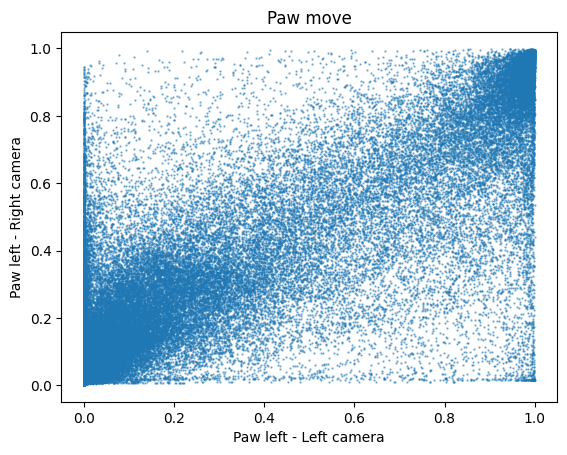

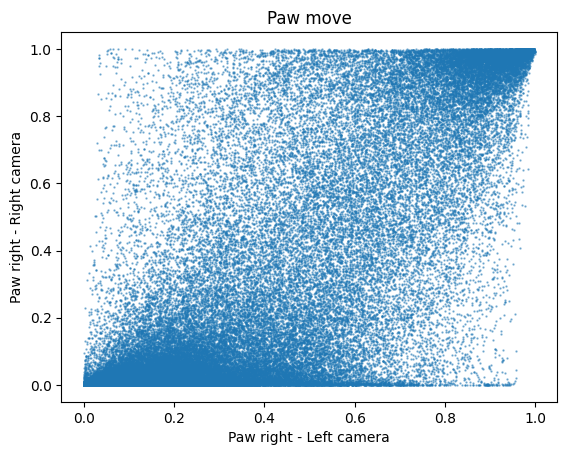

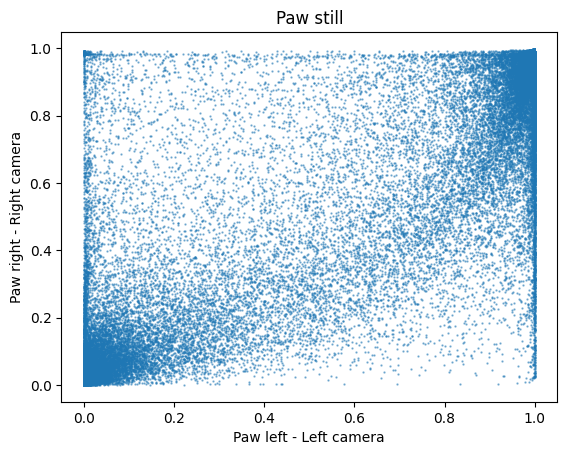

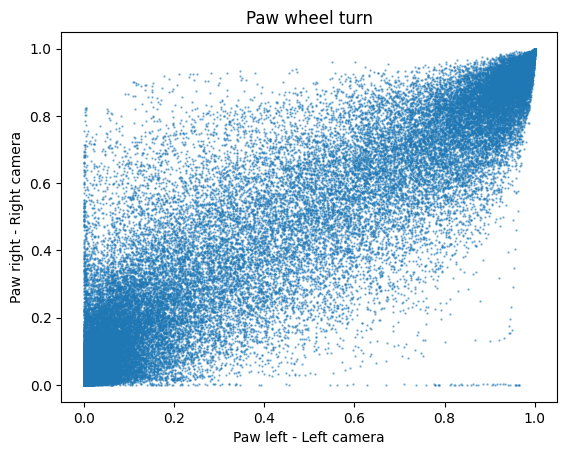

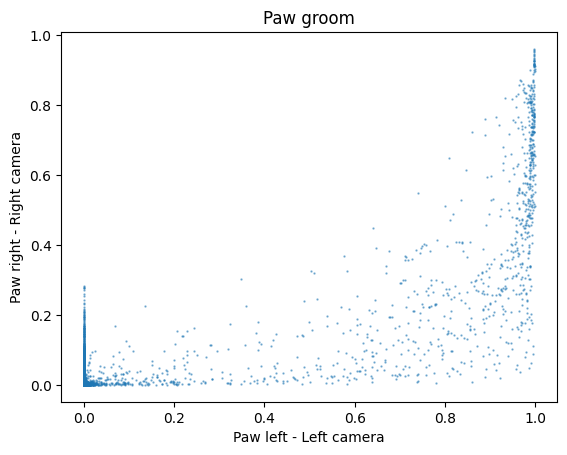

In [69]:
plt.scatter(design_matrix['leftCam_paw_r_move'], design_matrix['rightCam_paw_l_move'], alpha=.5, s=.5)
plt.xlabel('Paw left - Left camera')
plt.ylabel('Paw left - Right camera')
plt.title('Paw move')
plt.show()
plt.scatter(design_matrix['leftCam_paw_l_move'], design_matrix['rightCam_paw_r_move'], alpha=.5, s=.5)
plt.xlabel('Paw right - Left camera')
plt.ylabel('Paw right - Right camera')
plt.title('Paw move')
plt.show()

plt.scatter(design_matrix['leftCam_paw_r_still'], design_matrix['rightCam_paw_l_still'], alpha=.5, s=.5)
plt.xlabel('Paw left - Left camera')
plt.ylabel('Paw right - Right camera')
plt.title('Paw still')
plt.show()


plt.scatter(design_matrix['leftCam_paw_r_wheel_turn'], design_matrix['rightCam_paw_l_wheel_turn'], alpha=.5, s=.5)
plt.xlabel('Paw left - Left camera')
plt.ylabel('Paw right - Right camera')
plt.title('Paw wheel turn')
plt.show()


plt.scatter(design_matrix['leftCam_paw_r_groom'], design_matrix['rightCam_paw_l_groom'], alpha=.5, s=.5)
plt.xlabel('Paw left - Left camera')
plt.ylabel('Paw right - Right camera')
plt.title('Paw groom')
plt.show()


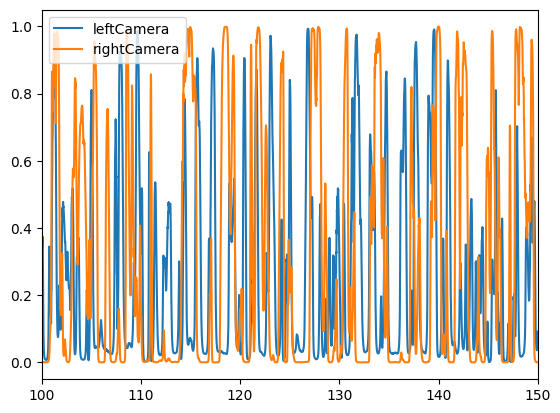

In [17]:
from matplotlib import pyplot as plt
init = 100
end = init+50
plt.plot(paws_states_leftCamera['times'], paws_states_leftCamera['paw_l_move'], label='leftCamera')
plt.plot(paws_states_rightCamera['times'], paws_states_rightCamera['paw_r_move'], label='rightCamera')
# plt.plot(times_l, paws_l['paw_l_wheel_turn'], label='wheel')
# plt.plot(times_l, paws_l['paw_l_groom'], label='groom')
plt.xlim([init, end])
plt.legend()
plt.show()


# Left camera

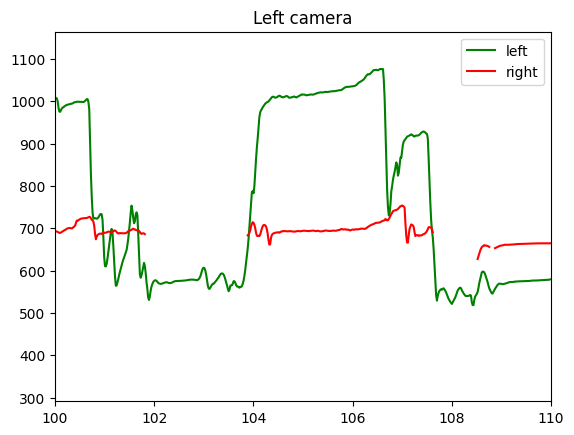

(100.0, 110.0)

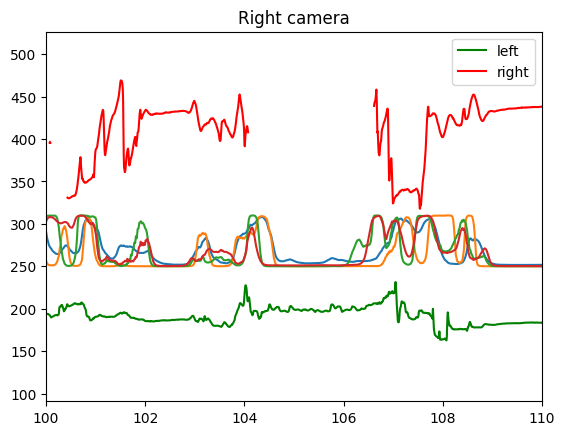

In [41]:
init = 100
end = init+10
l_paw_x = interpolate_nans(poses['leftCamera']['paw_r_x'], left_fr)
r_paw_x = interpolate_nans(poses['leftCamera']['paw_l_x'], left_fr)
plt.plot(times_l, l_paw_x, color='green', label='left')
plt.plot(times_l, r_paw_x, color='red', label='right')
# plt.plot(wheel_t, wheel_vel*20+500, color='black', label='wheel')
plt.xlim([init, end])
plt.legend()
plt.title('Left camera')
plt.show()
l_paw_x = interpolate_nans(poses['rightCamera']['paw_r_x'], right_fr)
r_paw_x = interpolate_nans(poses['rightCamera']['paw_l_x'], right_fr)
plt.plot(times_r, l_paw_x, color='green', label='left')
plt.plot(times_r, r_paw_x, color='red', label='right')
# plt.plot(wheel_t, wheel_vel*20+500, color='black', label='wheel')
plt.xlim([init, end])
plt.legend()
plt.title('Right camera')
# plt.show()
plt.plot(paws_states_leftCamera['times'], paws_states_leftCamera['paw_l_move']*60+250, label='leftCamera')
plt.plot(paws_states_rightCamera['times'], paws_states_rightCamera['paw_r_move']*60+250, label='rightCamera')
plt.plot(paws_states_leftCamera['times'], paws_states_leftCamera['paw_r_move']*60+250, label='leftCamera')
plt.plot(paws_states_rightCamera['times'], paws_states_rightCamera['paw_l_move']*60+250, label='rightCamera')
plt.xlim([init, end])
plt.xlim([init, end])


In [22]:
l_paw_x = interpolate_nans(poses['leftCamera']['paw_r_x'], left_fr)
r_paw_x = interpolate_nans(poses['leftCamera']['paw_l_x'], left_fr)

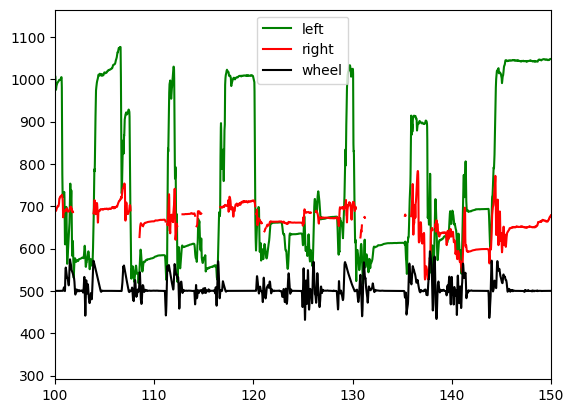

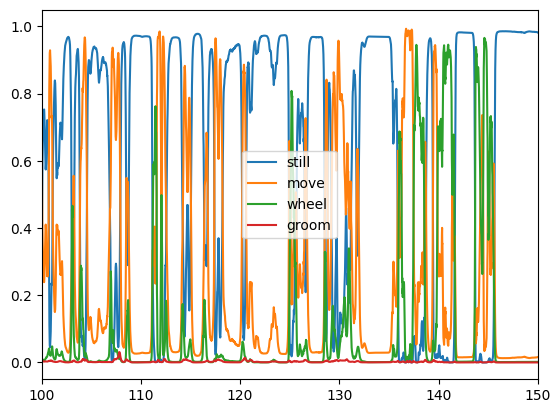

In [61]:
from matplotlib import pyplot as plt
import seaborn as sns
init = 100
end = init+50
plt.plot(times_l, l_paw_x, color='green', label='left')
plt.plot(times_l, r_paw_x, color='red', label='right')
plt.plot(wheel_t, wheel_vel*20+500, color='black', label='wheel')
plt.xlim([init, end])
plt.legend()
plt.show()
plt.plot(times_l, paws_l['paw_l_still'], label='still')
plt.plot(times_l, paws_l['paw_l_move'], label='move')
plt.plot(times_l, paws_l['paw_l_wheel_turn'], label='wheel')
plt.plot(times_l, paws_l['paw_l_groom'], label='groom')
plt.xlim([init, end])
plt.legend()
plt.show()
# plt.plot(times_l, paws_l['paw_r_still_ens_var'])
# plt.plot(times_l, paws_l['paw_r_move_ens_var'])
# plt.plot(times_l, paws_l['paw_r_wheel_turn_ens_var'])
# plt.plot(times_l, paws_l['paw_r_groom_ens_var'])
# plt.xlim([init, end])


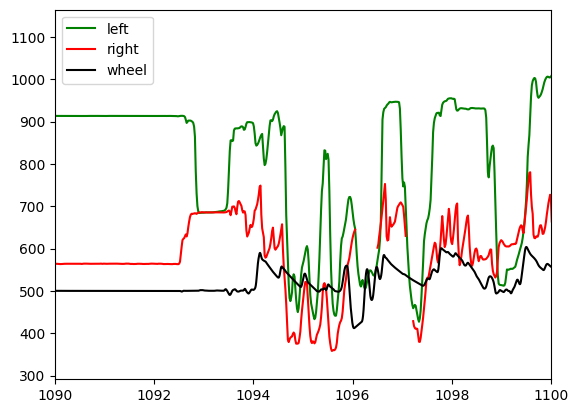

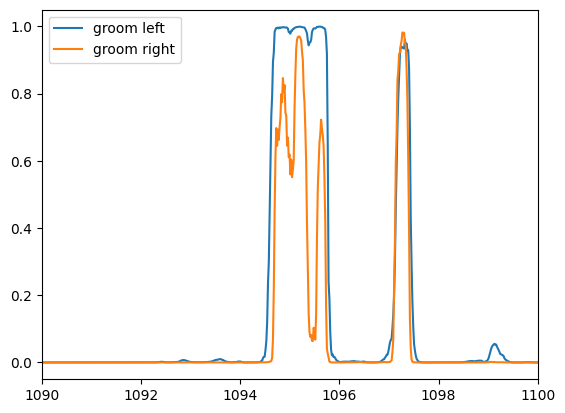

In [85]:
init = 1090
end = init+10
plt.plot(times_l, l_paw_x, color='green', label='left')
plt.plot(times_l, r_paw_x, color='red', label='right')
plt.plot(wheel_t, wheel_vel*20+500, color='black', label='wheel')
plt.xlim([init, end])
plt.legend()
plt.show()
plt.plot(times_l, paws_l['paw_l_groom'], label='groom left')
plt.plot(times_l, paws_l['paw_r_groom'], label='groom right')

plt.xlim([init, end])
plt.legend()
plt.show()

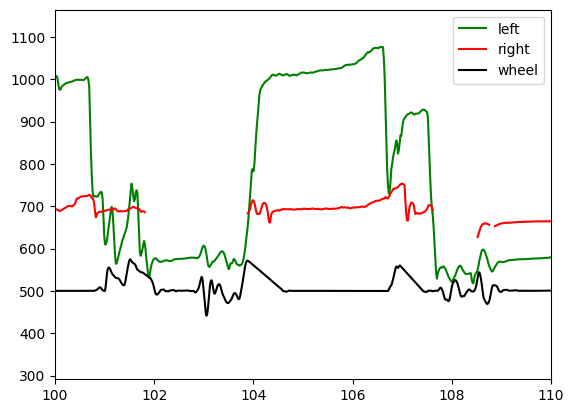

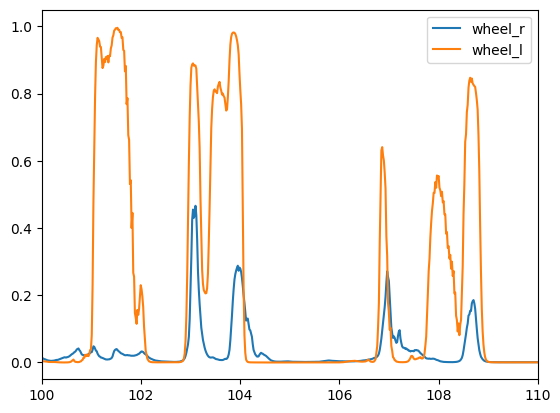

In [55]:
init = 100
end = init+10
plt.plot(times_l, l_paw_x, color='green', label='left')
plt.plot(times_l, r_paw_x, color='red', label='right')
plt.plot(wheel_t, wheel_vel*20+500, color='black', label='wheel')
plt.xlim([init, end])
plt.legend()
plt.show()

plt.plot(times_l, paws_l['paw_l_wheel_turn'], label='wheel_r')
plt.plot(times_l, paws_l['paw_r_wheel_turn'], label='wheel_l')
plt.xlim([init, end])
plt.legend()
plt.show()

In [19]:
times_l = one.load_dataset(session, '_ibl_%sCamera.times.npy' % 'left')
paws_l = one.load_dataset(session, '_ibl_%sCamera.pawstates.pqt' % 'left')


In [ ]:
plt.plot(times_l, l_paw_x, color='green')
plt.plot(times_l, r_paw_x, color='red')
plt.xlim([50, 60])